https://github.com/pcm-dpc/COVID-19

# Importing Libraries

In [1]:
# %pip install --upgrade pip
# %pip install dgl

In [2]:
# %pip install -r requirements.txt

In [3]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import dgl
import networkx as nx
import torch
import torch.nn.functional as F
import urllib.request
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from scipy.integrate import odeint
from scipy import integrate, optimize
from dgl.nn.pytorch.conv import GINConv
from dgl.nn.pytorch.glob import SumPooling, AvgPooling, MaxPooling
from datetime import datetime

c:\Users\Sudarshan Anand\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
use_cuda= torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("using " + ("gpu" if use_cuda else "cpu"))

np.random.seed(42) 

using cpu


# Reading csv

In [24]:

# covid_data_url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/refs/heads/master/dati-regioni/dpc-covid19-ita-regioni-20200224.csv"
# covid_data_file = 'dpc-covid19-ita-regioni-20200224.csv'
# urllib.request.urlretrieve(covid_data_url, covid_data_file)
covid_data_file = 'data/dpc-covid19-ita-regioni.csv'
df = pd.read_csv(covid_data_file)
df['data'] = pd.to_datetime(df['data'], format="%Y-%m-%dT%H:%M:%S")
df = df.fillna(0)
del df['note_test'], df['note_casi'], df['note']
df.head()

data stato  codice_regione denominazione_regione        lat  \
0 2020-02-24 18:00:00   ITA              13               Abruzzo  42.351222   
1 2020-02-24 18:00:00   ITA              17            Basilicata  40.639471   
2 2020-02-24 18:00:00   ITA              18              Calabria  38.905976   
3 2020-02-24 18:00:00   ITA              15              Campania  40.839566   
4 2020-02-24 18:00:00   ITA               8        Emilia-Romagna  44.494367   

        long  ricoverati_con_sintomi  terapia_intensiva  totale_ospedalizzati  \
0  13.398438                       0                  0                     0   
1  15.805148                       0                  0                     0   
2  16.594402                       0                  0                     0   
3  14.250850                       0                  0                     0   
4  11.341721                      10                  2                    12   

   isolamento_domiciliare  ...  totale_casi  tamponi  casi_testati  \
0                       0  ...            0        5           0.0   
1                       0  ...            0        0           0.0   
2                       0  ...            0        1           0.0   
3                       0  ...            0       10           0.0   
4                       6  ...           18      148           0.0   

   ingressi_terapia_intensiva  totale_positivi_test_molecolare  \
0                         0.0                              0.0   
1                         0.0                              0.0   
2                         0.0                              0.0   
3                         0.0                              0.0   
4                         0.0                              0.0   

   totale_positivi_test_antigenico_rapido  tamponi_test_molecolare  \
0                                     0.0                      0.0   
1                                     0.0                      0.0   
2                                     0.0                      0.0   
3                                     0.0                      0.0   
4                                     0.0                      0.0   

   tamponi_test_antigenico_rapido  codice_nuts_1  codice_nuts_2  
0                             0.0              0              0  
1                             0.0              0              0  
2                             0.0              0              0  
3                             0.0              0              0  
4                             0.0              0              0  

[5 rows x 27 columns]

In [25]:
df["denominazione_regione"].unique()

array(['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna',
       'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche',
       'Molise', 'P.A. Bolzano', 'P.A. Trento', 'Piemonte', 'Puglia',
       'Sardegna', 'Sicilia', 'Toscana', 'Umbria', "Valle d'Aosta",
       'Veneto'], dtype=object)

In [26]:
provinces = df.denominazione_regione.unique()
provinces_df = {p:df[df["denominazione_regione"]==p] for p in provinces}

# https://www.statista.com/statistics/617497/resident-population-italy-by-region/
provinces_population = {
    'Abruzzo': 1269963, 
    'Basilicata': 533636, 
    'Calabria': 1838150, 
    'Campania': 5590076, 
    'Emilia-Romagna': 4455188,
    'Friuli Venezia Giulia': 1195792, 
    'Lazio': 5720272, 
    'Liguria': 1508847, 
    'Lombardia': 10020528, 
    'Marche': 1484427,
    'Molise': 289413, 
    'P.A. Bolzano': 520891,
    'P.A. Trento': 1082116, 
    'Piemonte': 4252581, 
    'Puglia': 3890250,
    'Sardegna': 1569832,
    'Sicilia': 4794512, 
    'Toscana': 3664798, 
    'Umbria': 854378, 
    "Valle d'Aosta": 123018,
    'Veneto': 4851972,
}

In [27]:
# Dictionary to map original column names to English
column_translation = {
    'data': 'date',
    'stato': 'state',
    'codice_regione': 'region_code',
    'denominazione_regione': 'region_name',
    'lat': 'latitude',
    'long': 'longitude',
    'ricoverati_con_sintomi': 'hospitalized_with_symptoms',
    'terapia_intensiva': 'intensive_care',
    'totale_ospedalizzati': 'total_hospitalized',
    'isolamento_domiciliare': 'home_isolation',
    'totale_positivi': 'total_positive',
    'variazione_totale_positivi': 'total_positive_variation',
    'nuovi_positivi': 'new_positive',
    'dimessi_guariti': 'recovered',
    'deceduti': 'deceased',
    'casi_da_sospetto_diagnostico': 'cases_from_diagnostic_suspicion',
    'casi_da_screening': 'cases_from_screening',
    'totale_casi': 'total_cases',
    'tamponi': 'swabs',
    'casi_testati': 'cases_tested',
    'ingressi_terapia_intensiva': 'intensive_care_admissions',
    'totale_positivi_test_molecolare': 'total_positive_molecular_test',
    'totale_positivi_test_antigenico_rapido': 'total_positive_rapid_antigen_test',
    'tamponi_test_molecolare': 'molecular_test_swabs',
    'tamponi_test_antigenico_rapido': 'rapid_antigen_test_swabs',
    'codice_nuts_1': 'nuts_code_1',
    'codice_nuts_2': 'nuts_code_2'
}

# Rename the columns in the dataframe
df.rename(columns=column_translation, inplace=True)

# Update the provinces_df dictionary with the renamed columns
provinces_df = {p: df[df["region_name"] == p] for p in provinces}

In [28]:
df["date"].dt.year.unique()

array([2020, 2021, 2022, 2023, 2024], dtype=int64)

## Normalize Data

Normalizing the numeric columns

In [29]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != column_translation['codice_regione'] and col != 'lat' and col != 'long']

In [30]:
normalized_df = df.copy()
normalized_df[numeric_cols]=(df[numeric_cols]-df[numeric_cols].mean())/df[numeric_cols].std()

# EDA

## Trends

In [31]:
def getLinePlotByCol(col, title):
    fig, ax = plt.subplots(figsize=(12, 12))
    sns.lineplot(x=column_translation['data'], y=col, hue=column_translation['denominazione_regione'], data=df)
    plt.xticks(rotation=15)
    plt.title(title)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.show()

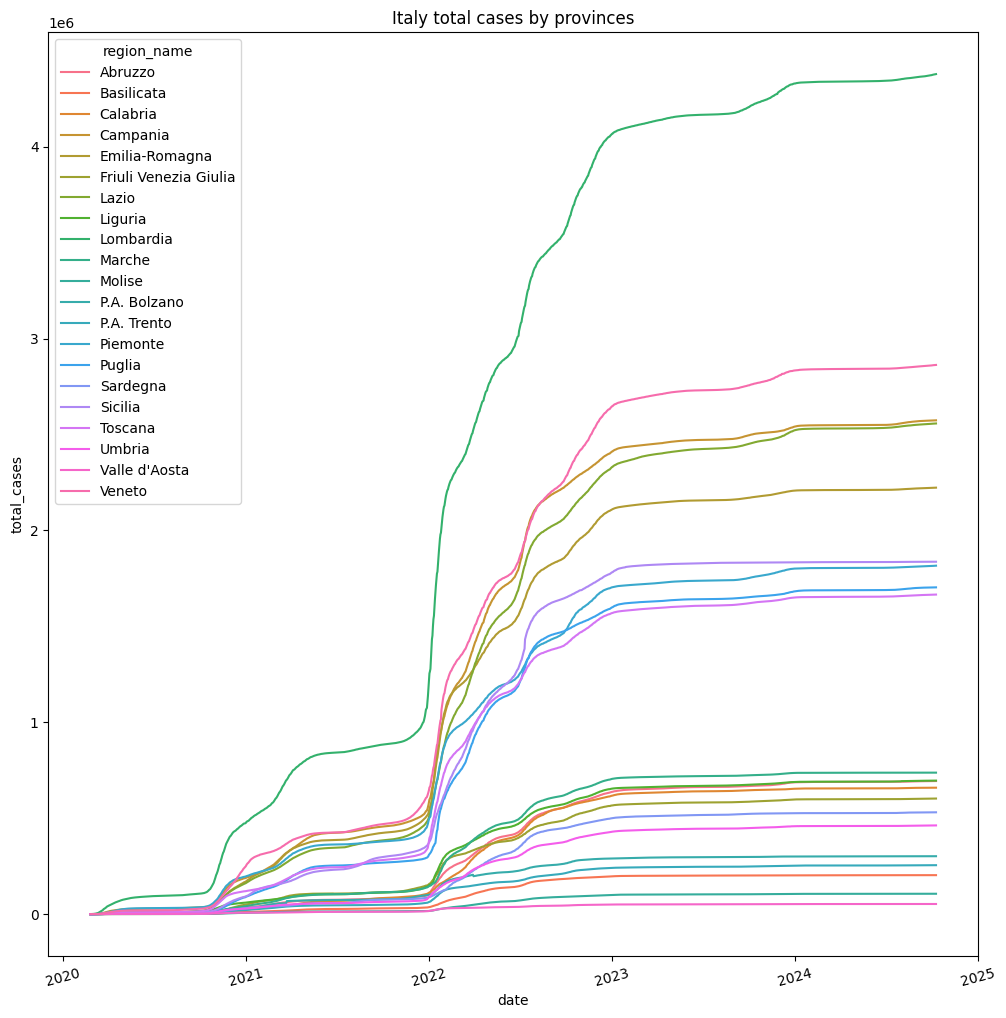

In [32]:
getLinePlotByCol(column_translation['totale_casi'], 'Italy total cases by provinces')

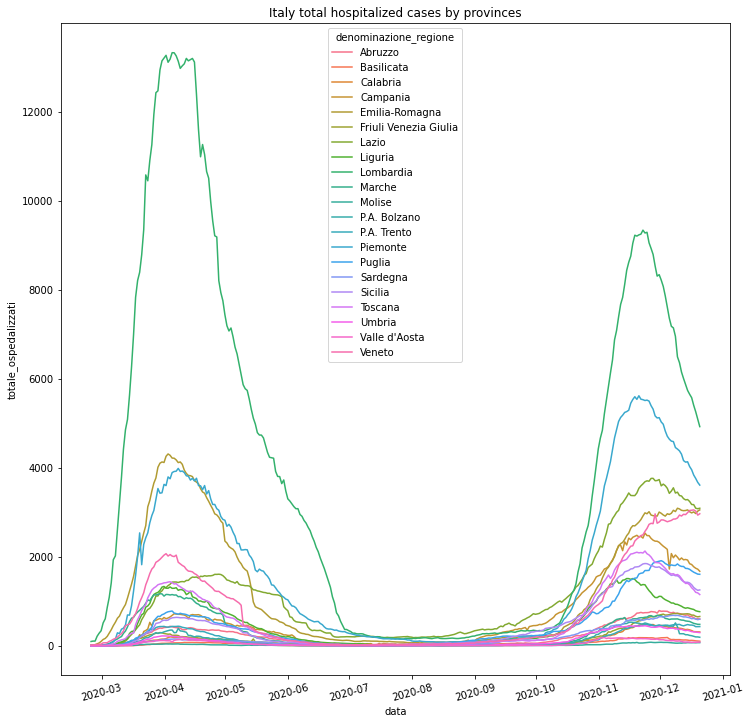

In [ ]:
getLinePlotByCol('totale_ospedalizzati', 'Italy total hospitalized cases by provinces')

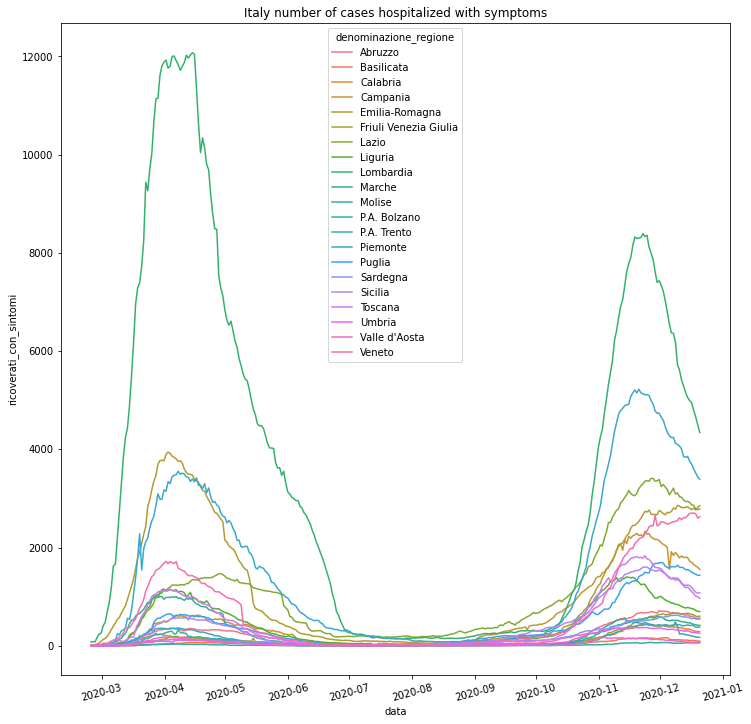

In [ ]:
getLinePlotByCol('ricoverati_con_sintomi', 'Italy number of cases hospitalized with symptoms')

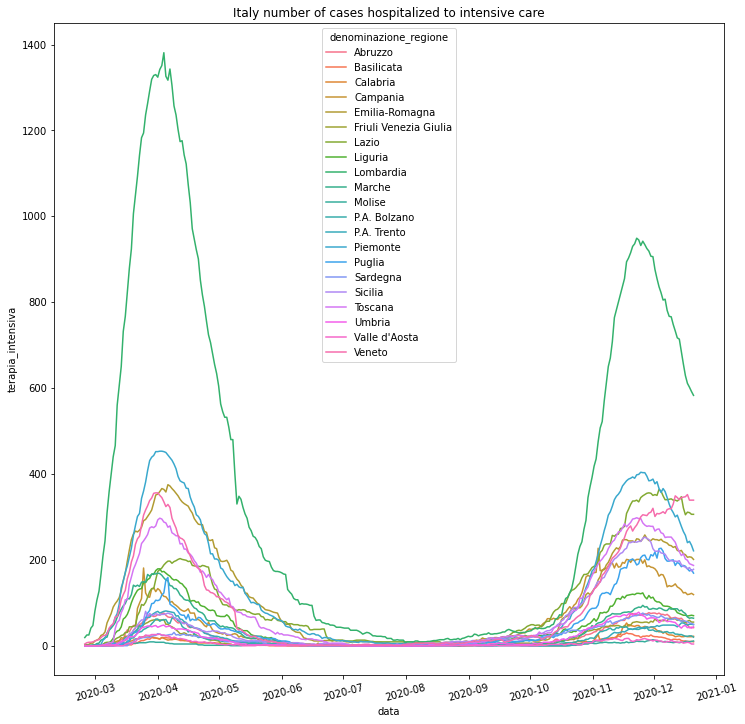

In [ ]:
getLinePlotByCol('terapia_intensiva', 'Italy number of cases hospitalized to intensive care')

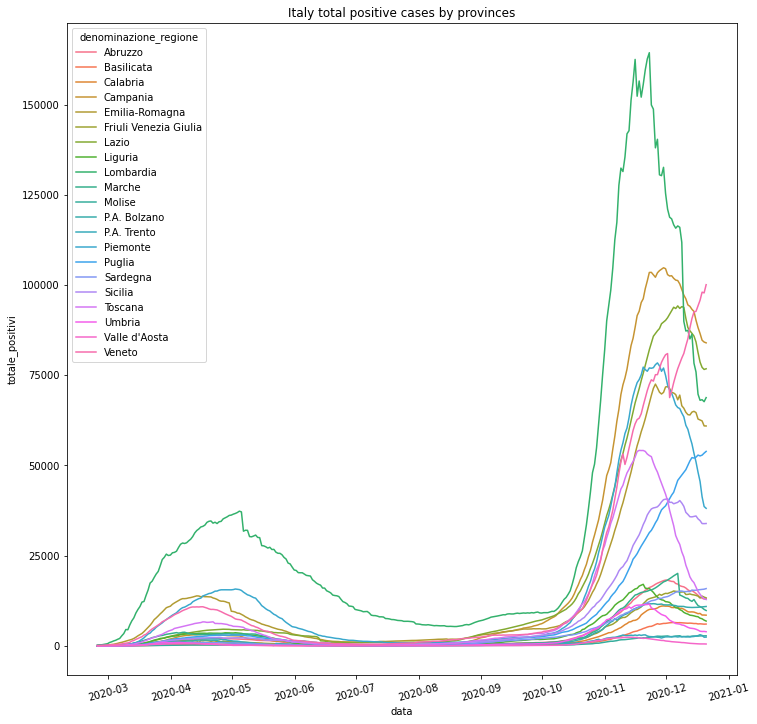

In [ ]:
getLinePlotByCol('totale_positivi', 'Italy total positive cases by provinces')

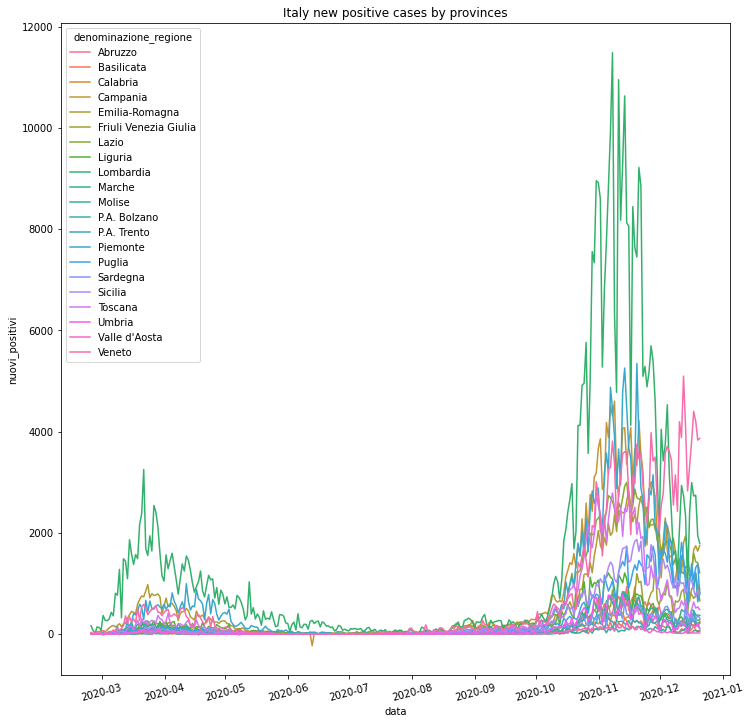

In [ ]:
getLinePlotByCol('nuovi_positivi', 'Italy new positive cases by provinces')

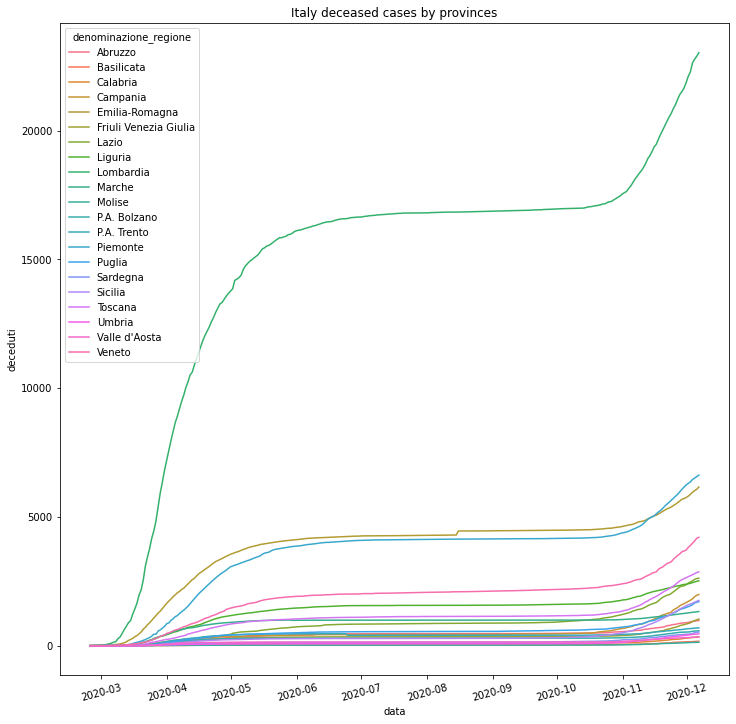

In [ ]:
getLinePlotByCol('deceduti', 'Italy deceased cases by provinces')

## Correlation

In [ ]:
def getCorrMap(df):
    corr = df.drop(['codice_regione','lat','long'],axis=1).corr()
    f, ax = plt.subplots(figsize=(12, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, cmap=cmap, square=True, linewidths=.5, annot=True)

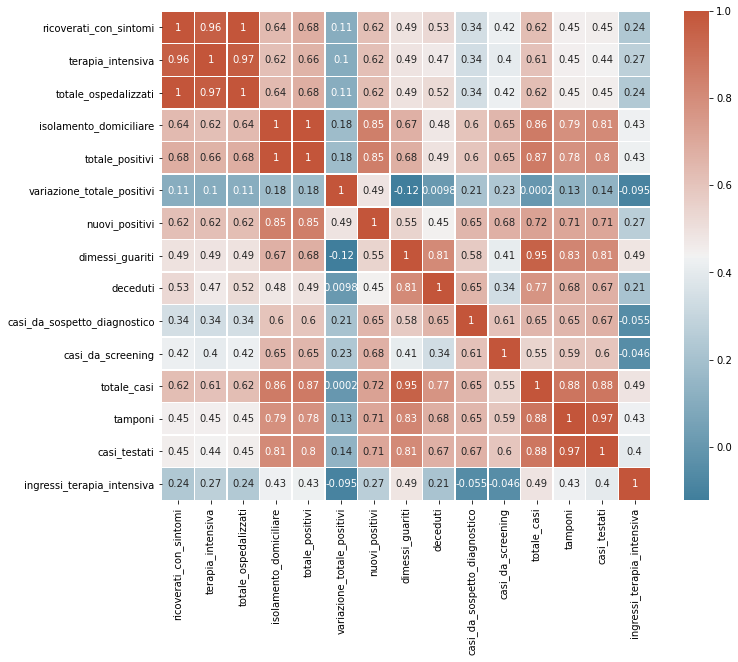

In [ ]:
getCorrMap(df)

# Machine Learning

## Create Training Data Set
To build the time series data for GNN, we must have dataset with shape of $N\times V \times K$ where $N$ is number of rows corresponding to each day, $V$ is number of nodes and $K$ is number of features for each node.

For our data, we have $N=287, V=21, K=20$ but not all features are useful

In [ ]:
target_col = 'totale_positivi'

In [ ]:
x = normalized_df.drop([
             target_col, 'stato', 'codice_regione', 'lat', 'long', 'data',
             'denominazione_regione', 'variazione_totale_positivi', 'isolamento_domiciliare'
             ], axis=1)

x['day_of_year'] = normalized_df['data'].dt.dayofyear

features = np.array(list(x.groupby(['day_of_year']).apply(pd.DataFrame.to_numpy)), dtype='float64')
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6321 entries, 0 to 6320
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ricoverati_con_sintomi        6321 non-null   float64
 1   terapia_intensiva             6321 non-null   float64
 2   totale_ospedalizzati          6321 non-null   float64
 3   isolamento_domiciliare        6321 non-null   float64
 4   nuovi_positivi                6321 non-null   float64
 5   dimessi_guariti               6321 non-null   float64
 6   deceduti                      6321 non-null   float64
 7   casi_da_sospetto_diagnostico  6321 non-null   float64
 8   casi_da_screening             6321 non-null   float64
 9   totale_casi                   6321 non-null   float64
 10  tamponi                       6321 non-null   float64
 11  casi_testati                  6321 non-null   float64
 12  ingressi_terapia_intensiva    6321 non-null   float64
 13  day

As for the node labels, we can do something similar to the dataset where the shape should be $N\times V$

In [ ]:
y = df[[target_col,'data']]
node_labels = np.array(list(y.groupby('data')[target_col].apply(pd.DataFrame.to_numpy)), dtype='float64')

In [ ]:
features = torch.from_numpy(features).to(device)
node_labels = torch.from_numpy(node_labels).to(device)
node_labels = node_labels.unsqueeze(2)

For our training purposes, we also need a training and validation mask for the graph

In [ ]:
def get_masks(train_size, shape):
    arr = np.zeros(shape)
    arr[:int(shape*train_size)] = 1
    np.random.shuffle(arr)
    return arr.astype('bool')

In [ ]:
train_mask = get_masks(0.8, node_labels.shape[1])
train_mask

array([ True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True, False,  True, False,  True,
        True,  True,  True])

Loss graphs

In [ ]:
def getLossGraph(t_loss, v_loss, invert=True):
    val_curve = pd.DataFrame.from_dict(v_loss, orient='index', columns=['validation loss'])
    val_curve['epoch'] = val_curve.index

    train_curve = pd.DataFrame.from_dict(t_loss, orient='index', columns=['training loss'])
    train_curve['epoch'] = train_curve.index

    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.scatterplot(x='epoch', y='training loss', data=train_curve, label="training")
    sns.scatterplot(x='epoch', y='validation loss', data=val_curve, label="validation")
    plt.title('Training loss and validation loss over epochs (Smooth L1 Loss)')
    plt.legend()
    if invert: plt.gca().invert_yaxis()
    plt.show()

## Feedforward NN

First we try a linear regression model that copies the output of a GNN, i.e. output (21,1) values where one target value for each of the 21 provinces

In [ ]:
def trainSimpleFNN(model, opt, loss_func, x, y, train_mask, rounds):
    train_losses = {}
    val_losses = {}
    for epoch in range(rounds):
        pred = model(x[:,train_mask==1].float())
        loss = loss_func(pred, y[:,train_mask==1].float())

        model.zero_grad()
        opt.zero_grad()
        loss.backward()
        opt.step()

        train_losses[epoch] = loss
        if epoch % 10 == 0:
            res = evaluate(model, x[:,train_mask==0], y[:,train_mask==0])
            val_losses[epoch] = res
            print("epoch {}: training loss: {}, validation loss: {}".format(epoch, loss, res))
    pred = model(x.float())
    return train_losses, val_losses, pred

In [ ]:
def evaluate(model, features, labels):
    model.eval()
    with torch.no_grad():
        logits = model(features.float())
        loss = torch.nn.functional.l1_loss(logits, labels)
        return loss

### Wide NN

In [ ]:
class WideNet(torch.nn.Module):
    def __init__(self, n_feature, n_hidden):
        super(WideNet, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden) # 301 x 21 x n => 301 x 21 x h
        self.output = torch.nn.Linear(n_hidden, 1) # 301 x 21 x h => 301 x 21 x 1
    
    def forward(self, x):
        x = F.leaky_relu(self.hidden(x))
        x = self.output(x)
        return x

In [ ]:
model = WideNet(n_feature=features.shape[2], n_hidden=500).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = torch.nn.SmoothL1Loss()
train_losses, val_losses, wnn_pred = trainSimpleFNN(model, opt, loss_func, features, node_labels, train_mask, 2000)

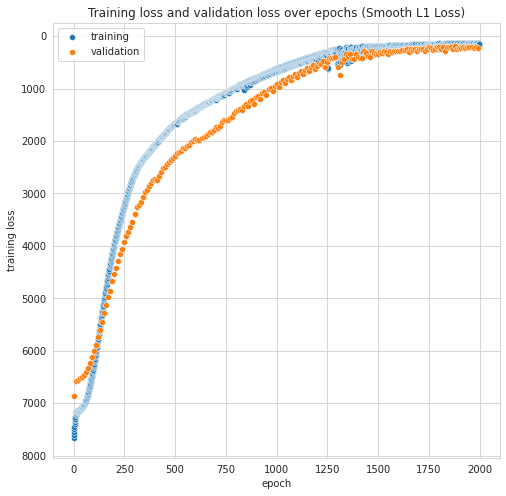

In [ ]:
getLossGraph(train_losses, val_losses, False)

In [ ]:
wnn_scores = []
for p in range(len(provinces)):
    score = mean_squared_log_error(node_labels.cpu()[:,p].detach().numpy(), wnn_pred.cpu()[:,p].detach().numpy().clip(min=0))
    print("score for province {}: {}".format(provinces[p], score))
    wnn_scores.append(score)
print("total score: {}".format(sum(wnn_scores)))

score for province Abruzzo: 0.470976508440173
score for province Basilicata: 1.2228329464292396
score for province Calabria: 3.781290769741725
score for province Campania: 1.2264703380096995
score for province Emilia-Romagna: 0.045657607923312665
score for province Friuli Venezia Giulia: 2.745628361806758
score for province Lazio: 0.17314612538466082
score for province Liguria: 0.5177236310199923
score for province Lombardia: 0.001091878334709809
score for province Marche: 0.3960458894897104
score for province Molise: 1.2077616342489328
score for province P.A. Bolzano: 0.467352235086108
score for province P.A. Trento: 3.8227079935194723
score for province Piemonte: 0.21545516955045244
score for province Puglia: 3.552728459892366
score for province Sardegna: 2.333693954478028
score for province Sicilia: 3.1425913128235914
score for province Toscana: 0.4009187449466454
score for province Umbria: 2.3139520076278104
score for province Valle d'Aosta: 0.7535680154712523
score for province Ve

### Deep NN

In [ ]:
class DeepNet(torch.nn.Module):
    def __init__(self, n_feature, n_hidden):
        super(DeepNet, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden) # 301 x 21 x n => 301 x 21 x h
        self.hidden1 = torch.nn.Linear(n_hidden, n_hidden) # 301 x 21 x h => 301 x 21 x h
        self.hidden2 = torch.nn.Linear(n_hidden, n_hidden) # 301 x 21 x h => 301 x 21 x h
        self.hidden3 = torch.nn.Linear(n_hidden, n_hidden) # 301 x 21 x h => 301 x 21 x h
        self.hidden4 = torch.nn.Linear(n_hidden, n_hidden) # 301 x 21 x h => 301 x 21 x h
        self.hidden5 = torch.nn.Linear(n_hidden, n_hidden) # 301 x 21 x h => 301 x 21 x h
        self.output = torch.nn.Linear(n_hidden, 1) # 301 x 21 x h => 301 x 21 x 1
    
    def forward(self, x):
        x = F.leaky_relu(self.hidden(x))
        x = F.leaky_relu(self.hidden1(x))
        x = F.leaky_relu(self.hidden2(x))
        x = F.leaky_relu(self.hidden3(x))
        x = F.leaky_relu(self.hidden4(x))
        x = F.leaky_relu(self.hidden5(x))
        x = self.output(x)
        return x

In [ ]:
model = DeepNet(n_feature=features.shape[2], n_hidden=50).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.005)
loss_func = torch.nn.SmoothL1Loss()
train_losses, val_losses, nn_pred = trainSimpleFNN(model, opt, loss_func, features, node_labels, train_mask, 2000)

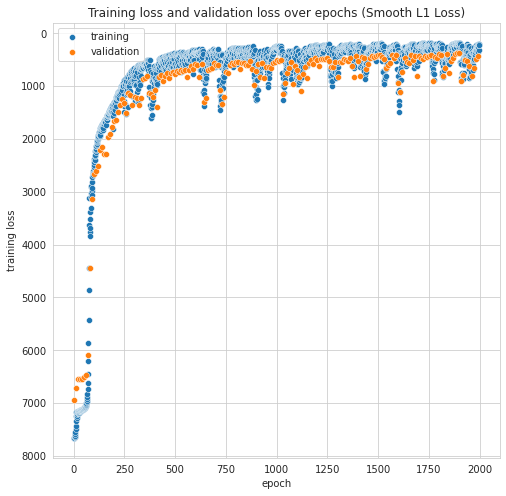

In [ ]:
getLossGraph(train_losses, val_losses, False)

In [ ]:
dnn_scores = []
for p in range(len(provinces)):
    score = mean_squared_log_error(node_labels.cpu()[:,p].detach().numpy(), nn_pred.cpu()[:,p].detach().numpy().clip(min=0))
    print("score for province {}: {}".format(provinces[p], score))
    dnn_scores.append(score)
print("total score: {}".format(sum(dnn_scores)))

score for province Abruzzo: 0.18576452750881103
score for province Basilicata: 1.6984605435361864
score for province Calabria: 3.310628181161193
score for province Campania: 0.19882733027237753
score for province Emilia-Romagna: 0.00836129770602428
score for province Friuli Venezia Giulia: 2.175825851271976
score for province Lazio: 0.05349829270848493
score for province Liguria: 0.10917907138003122
score for province Lombardia: 0.001119594128454839
score for province Marche: 0.18824489577412448
score for province Molise: 1.3698608372199133
score for province P.A. Bolzano: 0.2598041382433457
score for province P.A. Trento: 3.7045533351663122
score for province Piemonte: 0.06696742878870868
score for province Puglia: 3.0268300930418386
score for province Sardegna: 2.0516554569806247
score for province Sicilia: 2.5325385230376907
score for province Toscana: 0.18134421538825807
score for province Umbria: 2.5779128409617873
score for province Valle d'Aosta: 1.2999048843329706
score for pro

### Conclusion

In [ ]:
def getBarPlot(scores, cols):
    temp = pd.DataFrame(provinces, columns=['provinces'])
    for i in range(len(scores)):
        temp[cols[i]] = scores[i]
    tidy = temp.melt(id_vars='provinces').rename(columns=str.title)
    # return tidy
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.barplot(x='Provinces', y='Value', hue='Variable', data=tidy)
    plt.xticks(rotation=90)
    plt.show()

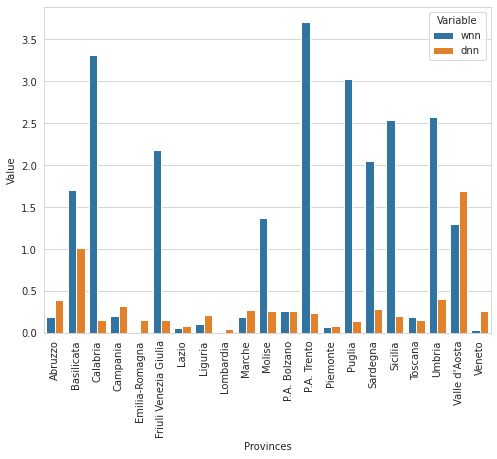

In [ ]:
getBarPlot([wnn_scores, dnn_scores], ['wnn', 'dnn'])

This concludes that a fully connected linear model cannot infer learnings from the neighbors

## GNN

### Create Graph 

Using the longtitude and latitude, we can calculate the distances (edges) between the provinces (nodes)

In [ ]:
def coorToDist(lat1, long1, lat2, long2):
    r = 6373.
    lat1 = math.radians(lat1)
    long1 = math.radians(long1)
    lat2 = math.radians(lat2)
    long2 = math.radians(long2)

    dlat = lat2 - lat1
    dlong = long2 - long1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlong / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return r * c

In [ ]:
g = nx.Graph()

for i in range(len(provinces)):
    for j in range(len(provinces)):
        if i != j:
            start = provinces_df[provinces[i]].head(1)
            end = provinces_df[provinces[j]].head(1)
            # dist = coorToDist(start['lat'], start['long'], end['lat'], end['long'])
            # g.add_edge(provinces[i], provinces[j], weight=dist)
            g.add_edge(provinces[i], provinces[j])

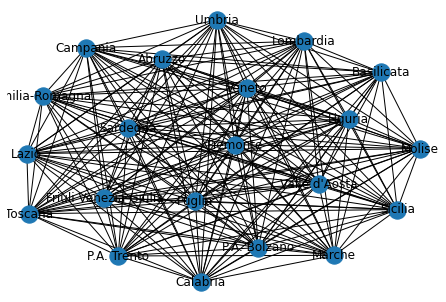

In [ ]:
nx.draw(g, with_labels=True)

In [ ]:
graph = dgl.from_networkx(g)
graph = dgl.add_self_loop(graph)
graph = graph.to(device)

### Training and Evaluation functions

In [ ]:
def save_checkpoint(checkpoint_path, model):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    state = {'state_dict': model.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)

def load_checkpoint(checkpoint_path, model):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    print('model loaded from %s' % checkpoint_path)


def train(model, loss_function, features, node_labels, train_mask, epoch_size, printSize=20):
    opt = torch.optim.Adam(model.parameters(), lr=0.003)
    val_mask = 1- train_mask
    model.train()
    train_losses = {}
    val_losses = {}
    for epoch in range(epoch_size):
        model.zero_grad()
        opt.zero_grad()

        preds = model(features.float()) # 21 x 301 x 14 => 21 x 301 x 1
        loss = loss_function(preds[train_mask], node_labels[train_mask].float())
        train_losses[epoch] = loss.item()

        loss.backward()
        opt.step()

        if epoch % printSize == 0:
            val = loss_function(preds[val_mask], node_labels[val_mask].float())
            val_losses[epoch] = val.item()
            print('epoch {}: with training loss: {}, validation loss: {}'.format(epoch, loss, val))
    preds = model(features.float())
    save_checkpoint("best_model.pth", model)
    return train_losses, val_losses, preds


### wide model

In [ ]:
class GIN2(torch.nn.Module):
    def __init__(self, graph, length, featuresSize, hiddenSize):
        super(GIN2, self).__init__()
        self.g = graph
        activationBlock1 = torch.nn.Sequential(
            torch.nn.Linear(featuresSize, hiddenSize), # 21 x 301 x f => 21 x 301 x h
            torch.nn.BatchNorm1d((length)),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hiddenSize, hiddenSize), # 21 x 301 x h => 21 x 301 x h
        )
        activationBlock3 = torch.nn.Sequential(
            torch.nn.Linear(hiddenSize, hiddenSize), # 21 x 301 x h => 21 x 301 x h
            torch.nn.BatchNorm1d((length)),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hiddenSize, 1), # 21 x 301 x h => 21 x 301 x 1
        )
        self.conv = GINConv(activationBlock1, aggregator_type='sum')
        self.conv3 = GINConv(activationBlock3, aggregator_type='sum')

    def forward(self, inputs):
        h = self.conv(self.g, inputs)
        h = F.leaky_relu(h)
        h = self.conv3(self.g, h)
        return h

In [ ]:
model = GIN2(graph, features.shape[0], features.shape[2], 500)
model = model.to(device)
g_features = torch.from_numpy(np.einsum('abc->bac', features.cpu())).to(device)
g_labels = torch.from_numpy(np.einsum('abc->bac', node_labels.cpu())).to(device)
loss = torch.nn.SmoothL1Loss()
train_losses, val_losses, gin2_pred = train(model, loss, g_features, g_labels, train_mask, 4000)

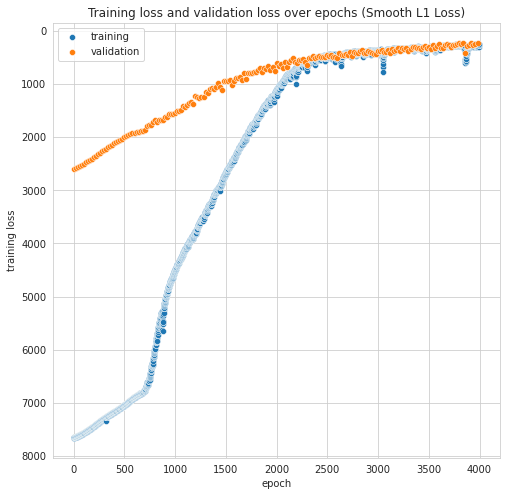

In [ ]:
getLossGraph(train_losses, val_losses)

In [ ]:
gin2_scores = []
for p in range(len(provinces)):
    score = mean_squared_log_error(g_labels.cpu()[p].detach().numpy(), gin2_pred.cpu()[p].detach().numpy().clip(min=0))
    print("score for province {}: {}".format(provinces[p], score))
    gin2_scores.append(score)
print("total score: {}".format(sum(gin2_scores)))

score for province Abruzzo: 0.09330995783967466
score for province Basilicata: 1.3307483336995751
score for province Calabria: 0.36375517920331274
score for province Campania: 0.11866722425150698
score for province Emilia-Romagna: 0.16262638230007467
score for province Friuli Venezia Giulia: 0.17044641656344733
score for province Lazio: 0.05650437105335086
score for province Liguria: 0.07019290689521127
score for province Lombardia: 0.2926211770865758
score for province Marche: 0.11544602191775345
score for province Molise: 0.5152480292453039
score for province P.A. Bolzano: 0.11984731006427023
score for province P.A. Trento: 0.3283191591108884
score for province Piemonte: 0.04332697347227791
score for province Puglia: 0.12208785497789741
score for province Sardegna: 0.712832185864138
score for province Sicilia: 0.12236704080255291
score for province Toscana: 0.02367171707343118
score for province Umbria: 1.1120249484798226
score for province Valle d'Aosta: 1.9828337763216122
score for

### deep model

In [ ]:
class GIN3(torch.nn.Module):
    def __init__(self, graph, length, featuresSize, hiddenSize):
        super(GIN3, self).__init__()
        self.g = graph
        activationBlock1 = torch.nn.Sequential(
            torch.nn.Linear(featuresSize, hiddenSize),
            torch.nn.BatchNorm1d((length)),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hiddenSize, hiddenSize),
            torch.nn.BatchNorm1d((length)),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hiddenSize, hiddenSize),
            torch.nn.BatchNorm1d((length)),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hiddenSize, hiddenSize),
        )
        activationBlock2 = torch.nn.Sequential(
            torch.nn.Linear(hiddenSize, hiddenSize),
            torch.nn.BatchNorm1d((length)),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hiddenSize, hiddenSize),
            torch.nn.BatchNorm1d((length)),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hiddenSize, hiddenSize),
            torch.nn.BatchNorm1d((length)),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hiddenSize, hiddenSize),
        )
        activationBlock3 = torch.nn.Sequential(
            torch.nn.Linear(hiddenSize, hiddenSize),
            torch.nn.BatchNorm1d((length)),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hiddenSize, hiddenSize),
            torch.nn.BatchNorm1d((length)),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hiddenSize, hiddenSize),
            torch.nn.BatchNorm1d((length)),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hiddenSize, hiddenSize),
            torch.nn.BatchNorm1d((length)),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hiddenSize, 1),
        )
        self.conv = GINConv(activationBlock1, aggregator_type='sum')
        self.conv2 = GINConv(activationBlock2, aggregator_type='sum')
        self.conv3 = GINConv(activationBlock3, aggregator_type='sum')

    def forward(self, inputs):
        h = self.conv(self.g, inputs)
        h = F.leaky_relu(h)
        h = self.conv2(self.g, h)
        h = F.leaky_relu(h)
        h = self.conv3(self.g, h)
        return h

In [ ]:
model = GIN3(graph, features.shape[0], features.shape[2], 50)
model = model.to(device)
g_features = torch.from_numpy(np.einsum('abc->bac', features.cpu())).to(device)
g_labels = torch.from_numpy(np.einsum('abc->bac', node_labels.cpu())).to(device)
loss = torch.nn.SmoothL1Loss()
train_losses, val_losses, gin3_pred = train(model, loss, g_features, g_labels, train_mask, 10000, 100)

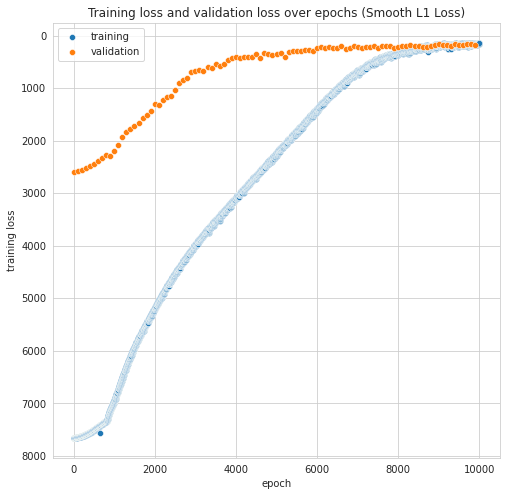

In [ ]:
getLossGraph(train_losses, val_losses)

In [ ]:
gin3_scores = []
for p in range(len(provinces)):
    score = mean_squared_log_error(g_labels.cpu()[p].detach().numpy(), gin3_pred.cpu()[p].detach().numpy().clip(min=0))
    print("score for province {}: {}".format(provinces[p], score))
    gin3_scores.append(score)
print("total score: {}".format(sum(gin3_scores)))

score for province Abruzzo: 0.08387469144847941
score for province Basilicata: 0.3943788357973371
score for province Calabria: 0.07907127975694177
score for province Campania: 0.4109916427889084
score for province Emilia-Romagna: 0.030179091070162593
score for province Friuli Venezia Giulia: 0.10779902454985454
score for province Lazio: 0.005174356684587437
score for province Liguria: 0.04243873325153372
score for province Lombardia: 0.00011144819427969703
score for province Marche: 0.02084829627689236
score for province Molise: 0.740583991922325
score for province P.A. Bolzano: 0.9684993414189165
score for province P.A. Trento: 0.16265839673718926
score for province Piemonte: 0.015807278205178982
score for province Puglia: 0.25674443509485917
score for province Sardegna: 0.11301242383273455
score for province Sicilia: 0.31416359944488237
score for province Toscana: 0.011945876790553074
score for province Umbria: 0.06704659249777689
score for province Valle d'Aosta: 0.2270660826055117


### GNN Conclusion

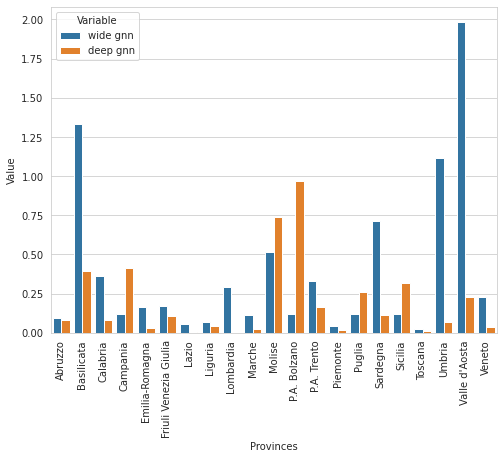

In [ ]:
getBarPlot([gin2_scores, gin3_scores], ['wide gnn', 'deep gnn'])

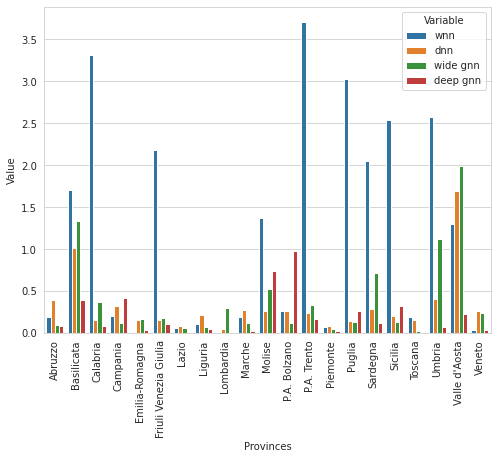

In [ ]:
getBarPlot([wnn_scores, dnn_scores, gin2_scores, gin3_scores], ['wnn', 'dnn', 'wide gnn', 'deep gnn'])

We can observe that GNN is much more capable to capture neighborhood information given that further training does not lead to a dramatic model failure like the simple Linear neural net

## SIR GNN
add SIR model prediction as a feature
g_features shape: 21 x 301 x 14 => 21 x 301 x 15

In [ ]:
sir_results_tensor = torch.from_numpy(np.expand_dims(np.array(sir_results),axis=2)).to(device)
graph_sir_features = torch.cat((g_features, sir_results_tensor), 2)

In [ ]:
model(graph_sir_features.float())[train_mask.astype('bool')].shape

torch.Size([16, 301, 1])

In [ ]:
model = GIN3(graph, features.shape[0], graph_sir_features.shape[2], 50)
model = model.to(device)

g_labels = torch.from_numpy(np.einsum('abc->bac', node_labels.cpu())).to(device)
loss = torch.nn.SmoothL1Loss()
train_losses, val_losses, gin_sir_pred = train(model, loss, graph_sir_features, g_labels, train_mask, 10000, 100)

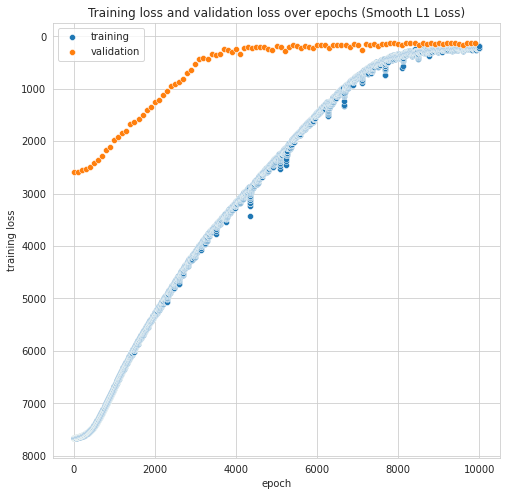

In [ ]:
getLossGraph(train_losses, val_losses)

In [ ]:
gin_sir_scores = []
for p in range(len(provinces)):
    score = mean_squared_log_error(g_labels.cpu()[p].detach().numpy(), gin_sir_pred.cpu()[p].detach().numpy().clip(min=0))
    print("score for province {}: {}".format(provinces[p], score))
    gin_sir_scores.append(score)
print("total score: {}".format(sum(gin_sir_scores)))

score for province Abruzzo: 0.05719248031706415
score for province Basilicata: 0.435267849665999
score for province Calabria: 0.08161690000078389
score for province Campania: 0.35287504723035473
score for province Emilia-Romagna: 0.05575118882522653
score for province Friuli Venezia Giulia: 0.09612986530508853
score for province Lazio: 0.040471022248164595
score for province Liguria: 0.030279882232556395
score for province Lombardia: 0.08057261529694472
score for province Marche: 0.01892153498540027
score for province Molise: 0.2411222113971397
score for province P.A. Bolzano: 0.5698791080639185
score for province P.A. Trento: 0.19622706968353978
score for province Piemonte: 0.024717074039897067
score for province Puglia: 0.25399148474054156
score for province Sardegna: 0.32384556334982606
score for province Sicilia: 0.22463776772767333
score for province Toscana: 0.02088191300688954
score for province Umbria: 0.12983306866251781
score for province Valle d'Aosta: 0.3291805998969771
sco

## Performance overview

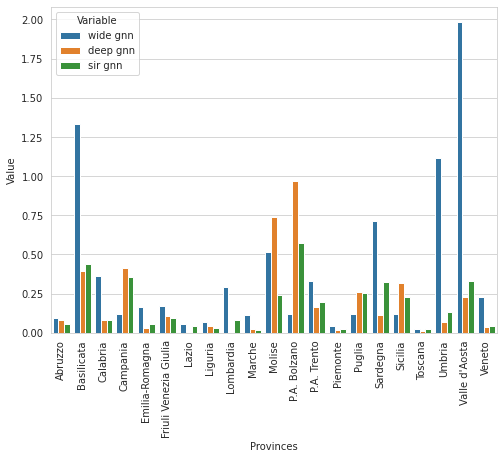

In [ ]:
getBarPlot([gin2_scores, gin3_scores, gin_sir_scores], ['wide gnn', 'deep gnn', 'sir gnn'])

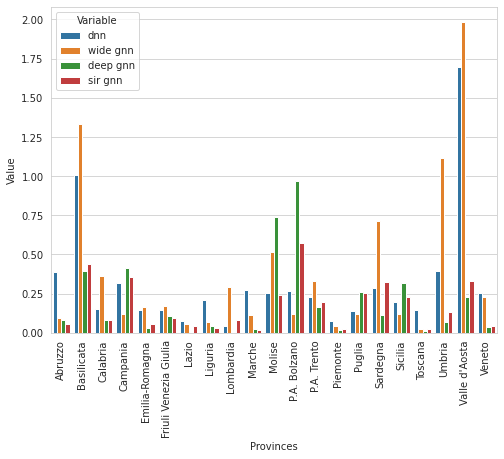

In [ ]:
getBarPlot([wnn_scores, dnn_scores, gin2_scores, gin3_scores, gin_sir_scores], ['wnn', 'dnn', 'wide gnn', 'deep gnn', 'sir gnn'])

#SIR Model

In [ ]:
# The sir main model
def SIR_fit(region, wave_number = 2, starting_day = 1):
    region_df = provinces_df[region]
    cutoff_date = "2020-08-01"
    if wave_number == 1:
      region_df = region_df[region_df["data"] < cutoff_date]
    else:
      region_df = region_df[region_df["data"] >= cutoff_date]
    population = float(provinces_population[region])

    country_df = pd.DataFrame()
    country_df['ConfirmedCases'] = region_df.totale_positivi
    country_df['RemovedCases'] = region_df.dimessi_guariti + region_df.deceduti
    country_df = country_df[starting_day:] #Choice of starting day.
    country_df['day_count'] = list(range(1,len(country_df)+1))

    ydata = [i for i in country_df.ConfirmedCases]
    removed_data = [i for i in country_df.RemovedCases]
    xdata = country_df.day_count
    ydata = np.array(ydata, dtype=float)
    xdata = np.array(xdata, dtype=float)

    N =  population
    init_case = ydata[0]
    init_removed = removed_data[0]
    S_0 = (N-init_case-init_removed)
    I_0 = init_case
    R_0 = init_removed

    def sir_differentials(y, x, beta, gamma):
      S, I, R = y 
      sus = (-beta*S*I)/N
      rec = gamma*I
      inf = -(sus + rec)
      return sus, inf, rec

    def fit_odeint(x, beta, gamma):
      return integrate.odeint(sir_differentials, (S_0, I_0, R_0), x, args=(beta, gamma))[:,1]

    popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata, maxfev=10000)
    fitted = fit_odeint(xdata, *popt)

    plt.plot(xdata, ydata, 'o')
    plt.plot(xdata, fitted)
    plt.title(f"Fit of SIR model for {region} infected cases for {wave_number} wave")
    plt.ylabel("Population infected")
    plt.xlabel("Days")
    plt.show()
    print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

    return fitted

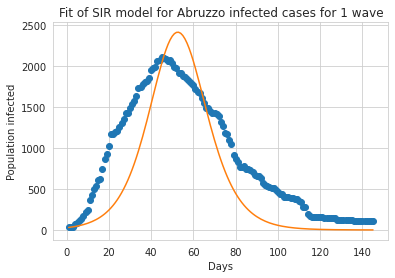

Optimal parameters: beta = 1.8667491232596742  and gamma =  1.7551690948909213


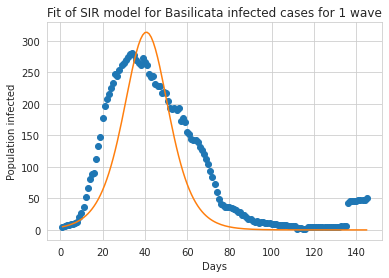

Optimal parameters: beta = -4.105453328519915  and gamma =  -4.242889748055244


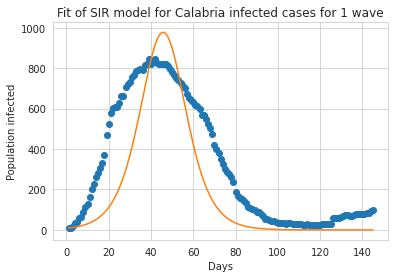

Optimal parameters: beta = -4.223514993187244  and gamma =  -4.35821517460429


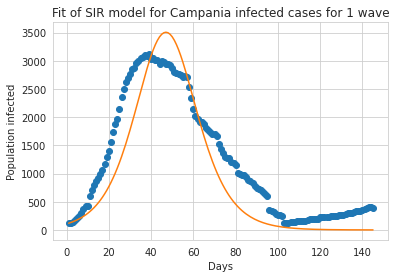

Optimal parameters: beta = 2.9941498373757667  and gamma =  2.8922239921020596


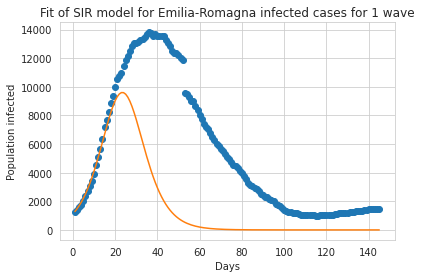

Optimal parameters: beta = 2.298929205074164  and gamma =  2.1593244961022666


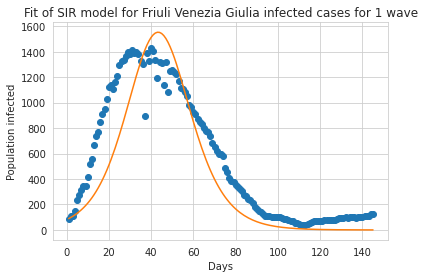

Optimal parameters: beta = 1.9934718558701954  and gamma =  1.89610291315513


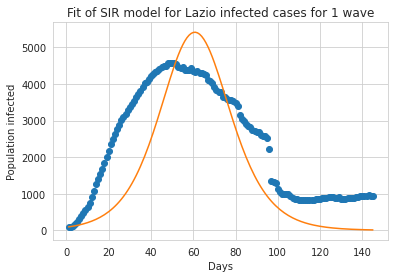

Optimal parameters: beta = 2.137946699066847  and gamma =  2.0475080233110514


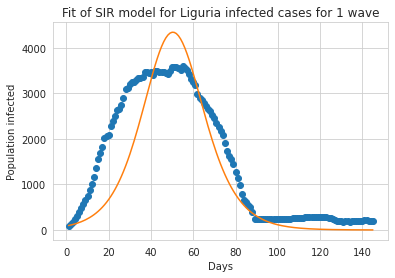

Optimal parameters: beta = 1.4248632492927094  and gamma =  1.320383230993689


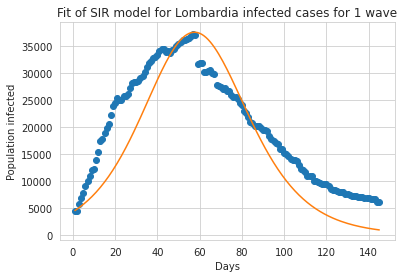

Optimal parameters: beta = 0.7233493679504948  and gamma =  0.6651616917479691


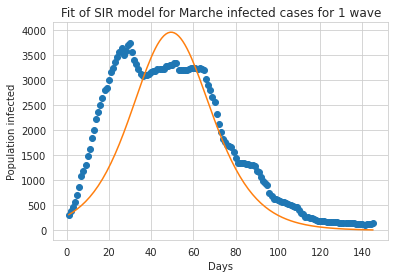

Optimal parameters: beta = 1.1314859269486512  and gamma =  1.0537770625395242


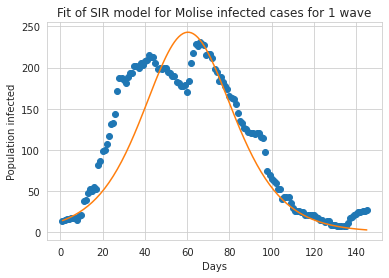

Optimal parameters: beta = 1.7871266067954539  and gamma =  1.7179469672858179


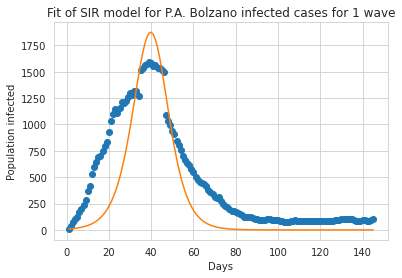

Optimal parameters: beta = -2.0036986364256952  and gamma =  -2.17564591621824


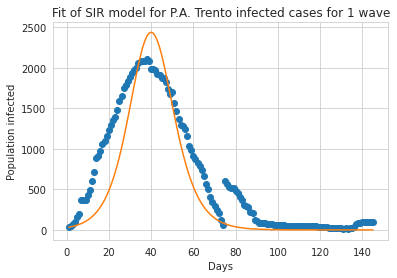

Optimal parameters: beta = 1.5670747025557556  and gamma =  1.4211252287896208


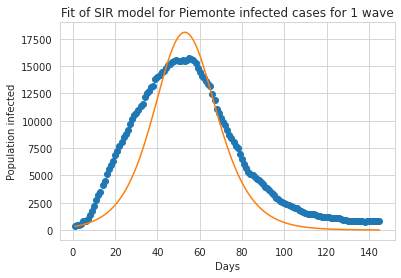

Optimal parameters: beta = 1.1568757101948601  and gamma =  1.0537294620486797


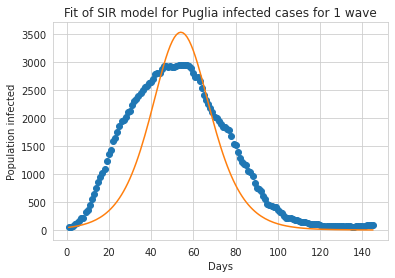

Optimal parameters: beta = 2.593604627164789  and gamma =  2.486073608071305


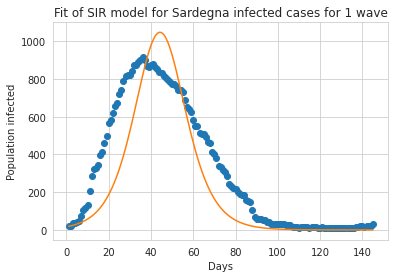

Optimal parameters: beta = 3.504850547981684  and gamma =  3.381030904538635


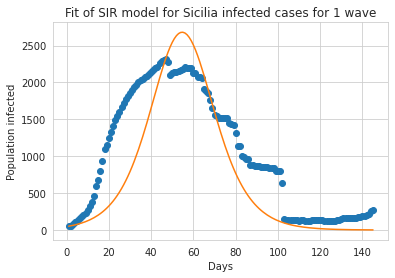

Optimal parameters: beta = 3.040239678883613  and gamma =  2.94184841715274


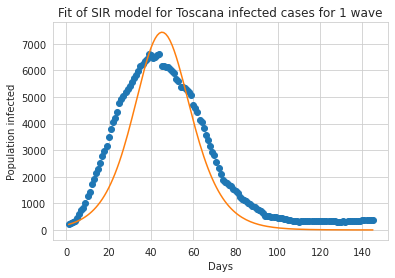

Optimal parameters: beta = 1.8023787043167654  and gamma =  1.6911155860976341


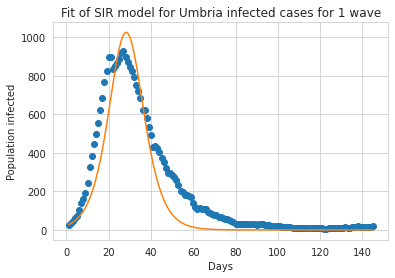

Optimal parameters: beta = 3.827330990402891  and gamma =  3.6463634680230377


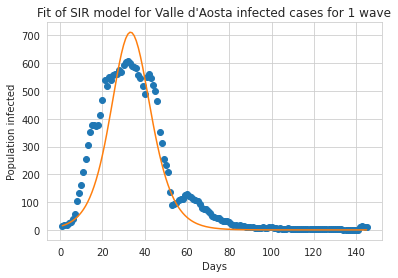

Optimal parameters: beta = 1.564259707836469  and gamma =  1.4021555500105787


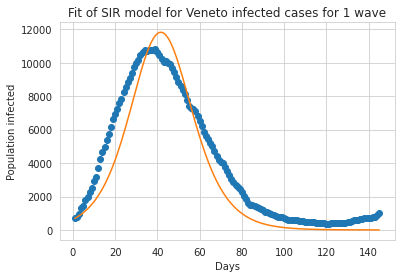

Optimal parameters: beta = 1.5131216344829346  and gamma =  1.4121277296723664


In [ ]:
sir_results=[]
for i in range(len(provinces)):
    fitted = SIR_fit(provinces[i], 1, 14)
    sir_results.append([0 for _ in range(15)])
    sir_results[i] += list(fitted)

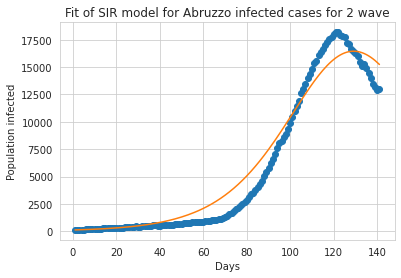

Optimal parameters: beta = 0.32443981541655964  and gamma =  0.2737055985268287


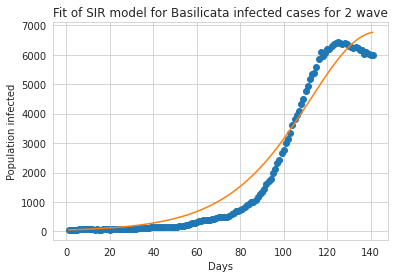

Optimal parameters: beta = 0.2940190747985753  and gamma =  0.24930334364893444


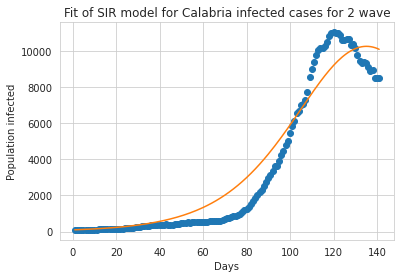

Optimal parameters: beta = 0.4471027579574108  and gamma =  0.401705104845107


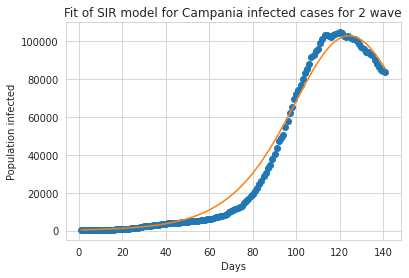

Optimal parameters: beta = 0.3122280973448815  and gamma =  0.2550676785369062


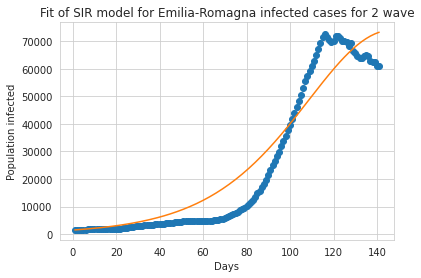

Optimal parameters: beta = 0.20778532967281063  and gamma =  0.17023398623382677


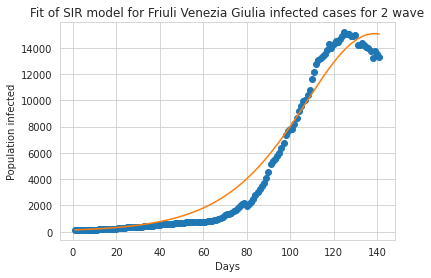

Optimal parameters: beta = 0.2915463661926714  and gamma =  0.24623375966874486


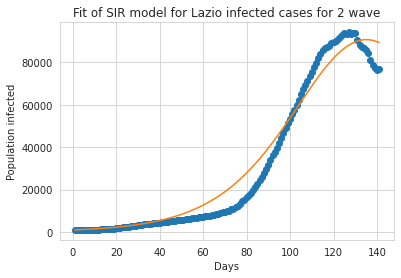

Optimal parameters: beta = 0.26281120846745565  and gamma =  0.21784027396205546


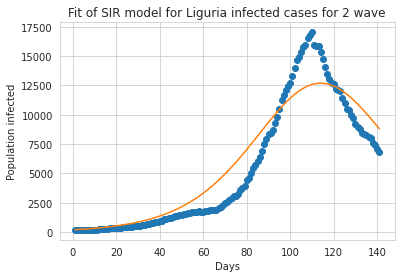

Optimal parameters: beta = 0.3901565217875665  and gamma =  0.33918859459065914


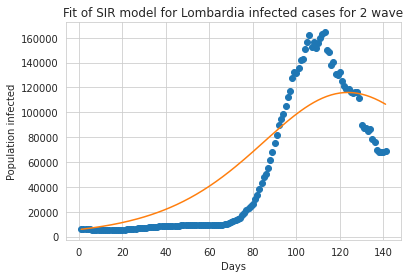

Optimal parameters: beta = 0.24517536193529582  and gamma =  0.20771530562540738


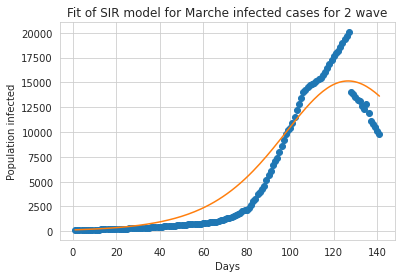

Optimal parameters: beta = 0.3521052933384329  and gamma =  0.3022967619789848


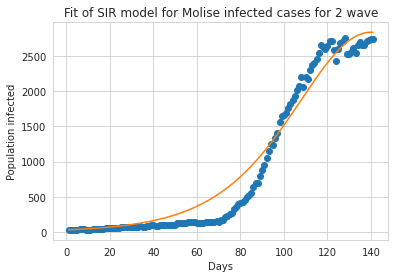

Optimal parameters: beta = 0.3205274933072464  and gamma =  0.27736506001049355


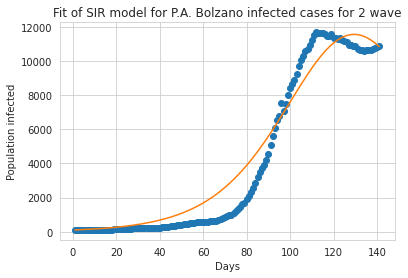

Optimal parameters: beta = 0.23717404454252652  and gamma =  0.18811931098462834


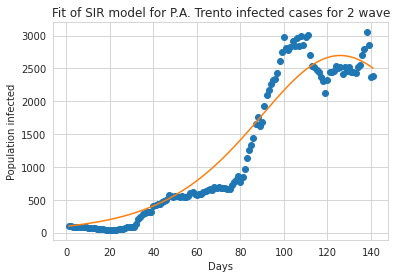

Optimal parameters: beta = 0.3853967894339021  and gamma =  0.34476657359947954


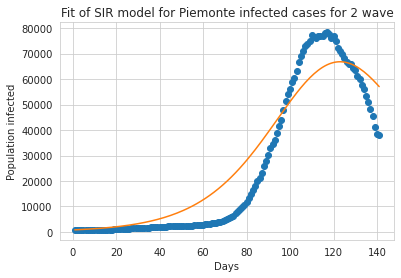

Optimal parameters: beta = 0.28411831546609656  and gamma =  0.23414207176968616


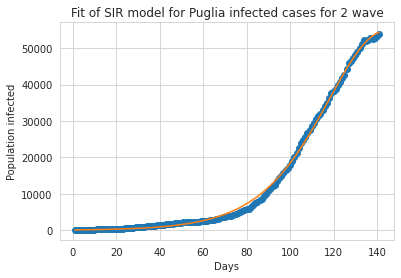

Optimal parameters: beta = 0.32944557340630004  and gamma =  0.27622119499062314


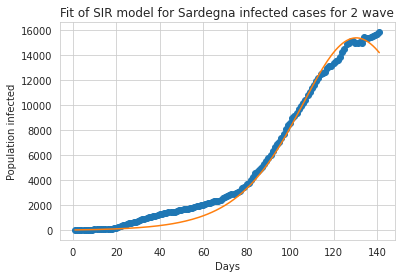

Optimal parameters: beta = 0.4224385813650723  and gamma =  0.36548250041891817


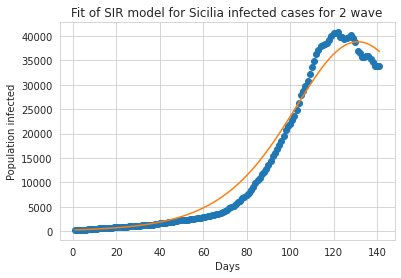

Optimal parameters: beta = 0.3994050192601101  and gamma =  0.3504741434875865


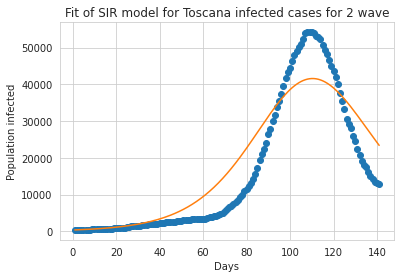

Optimal parameters: beta = 0.38373171878294743  and gamma =  0.3270951040061153


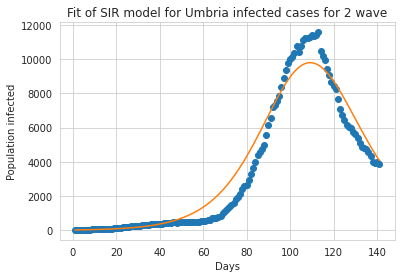

Optimal parameters: beta = 0.4699204149466952  and gamma =  0.4009357762849856


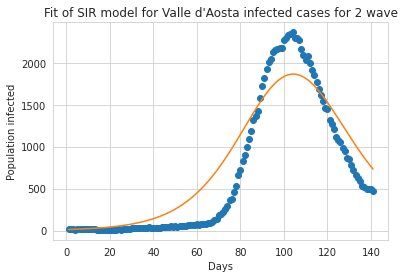

Optimal parameters: beta = 0.37398947375960945  and gamma =  0.30832463280897554


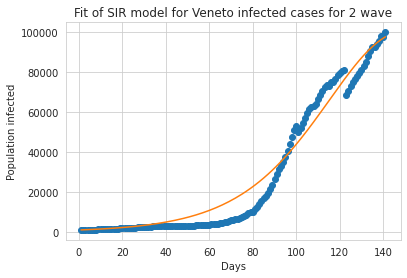

Optimal parameters: beta = 0.20848468401982143  and gamma =  0.1671437906026344


In [ ]:
for i in range(len(provinces)):
    fitted = SIR_fit(provinces[i], 2)
    sir_results[i] += list(fitted)

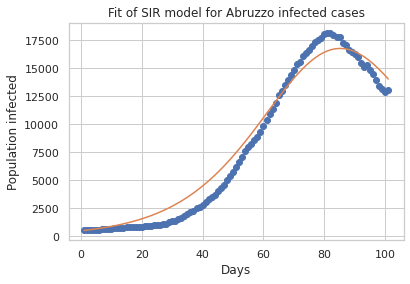

Optimal parameters: beta = 0.3713478026943409  and gamma =  0.3141853008576739


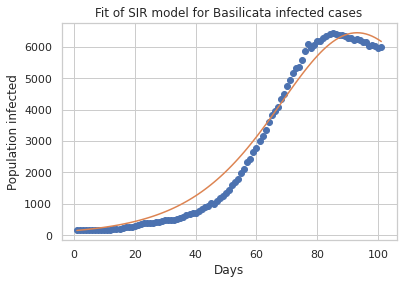

Optimal parameters: beta = 0.3794960542087201  and gamma =  0.323777380862313


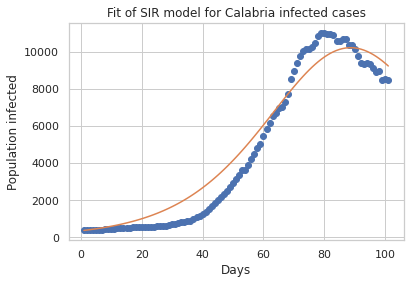

Optimal parameters: beta = 0.5333325753202341  and gamma =  0.4802002571968931


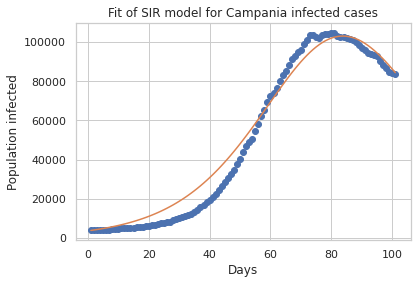

Optimal parameters: beta = 0.313267747954443  and gamma =  0.25687760632158074


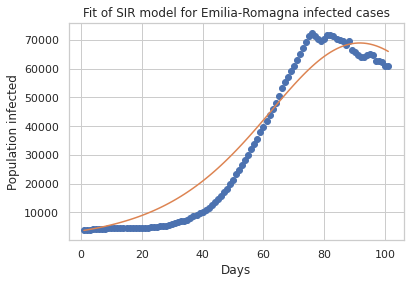

Optimal parameters: beta = 0.2816623098963261  and gamma =  0.23470238721678627


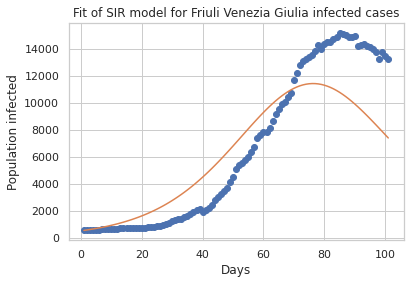

Optimal parameters: beta = 0.43891583411031204  and gamma =  0.38129112652608127


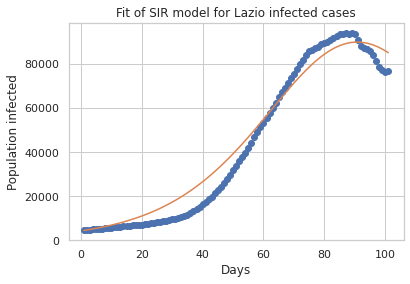

Optimal parameters: beta = 0.2909182114119632  and gamma =  0.24247928945652786


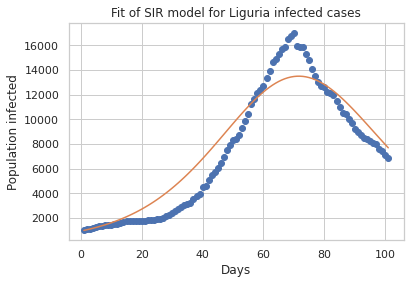

Optimal parameters: beta = 0.43931113772928865  and gamma =  0.3843065742963144


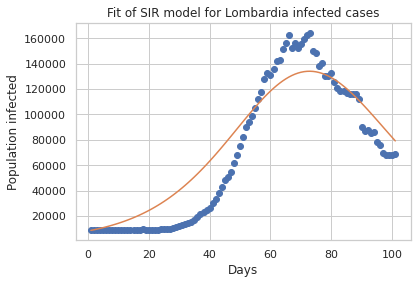

Optimal parameters: beta = 0.36660831395549615  and gamma =  0.3100847394726294


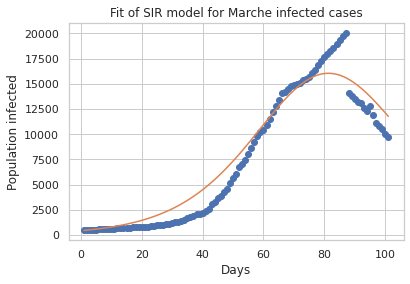

Optimal parameters: beta = 0.43689756108291994  and gamma =  0.37570947824696166


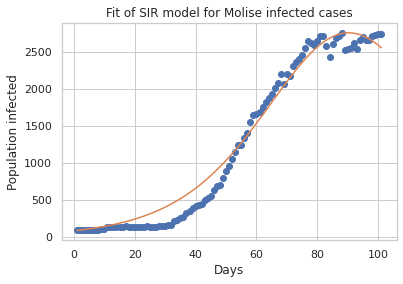

Optimal parameters: beta = 0.41370332370777135  and gamma =  0.35983228875265766


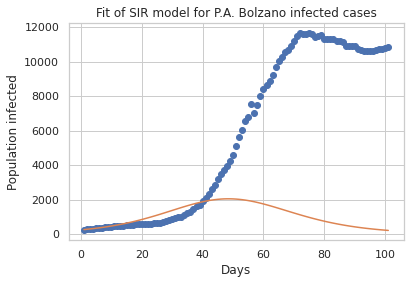

Optimal parameters: beta = 0.829287904523931  and gamma =  0.76118704127904


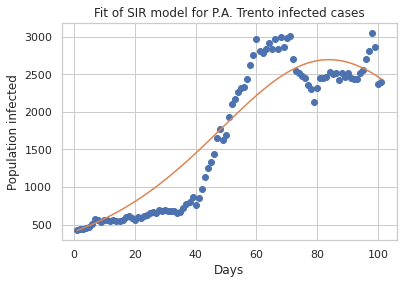

Optimal parameters: beta = 0.391591990562145  and gamma =  0.35587958121009017


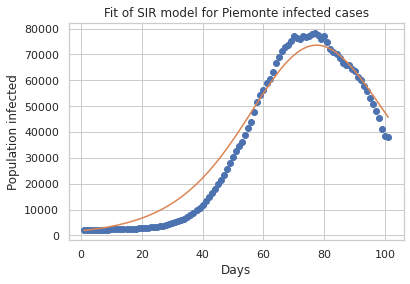

Optimal parameters: beta = 0.372975408239563  and gamma =  0.3071483986477409


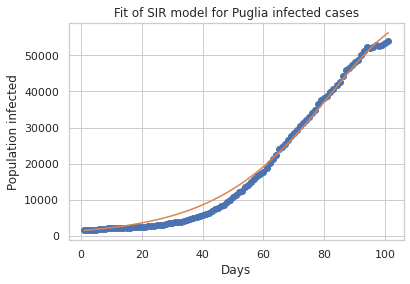

Optimal parameters: beta = 0.2723722649012724  and gamma =  0.22711676273011697


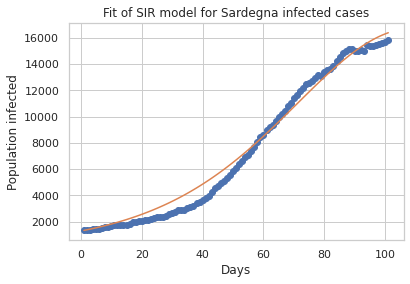

Optimal parameters: beta = 0.259792759345863  and gamma =  0.2247362646628118


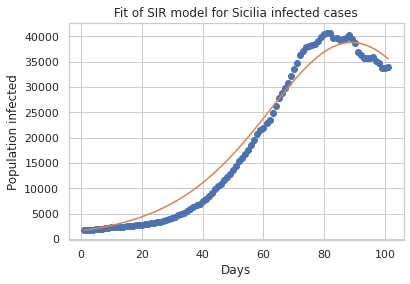

Optimal parameters: beta = 0.4223705518764352  and gamma =  0.3716746987414499


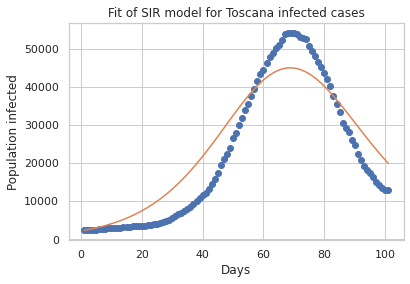

Optimal parameters: beta = 0.4284017063120404  and gamma =  0.3649753775525567


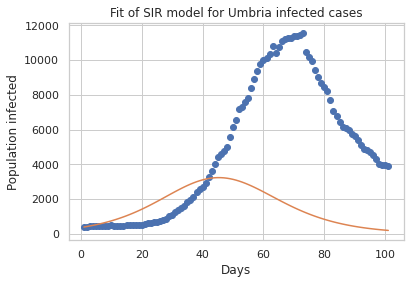

Optimal parameters: beta = 0.9230965508990191  and gamma =  0.8495332064653635


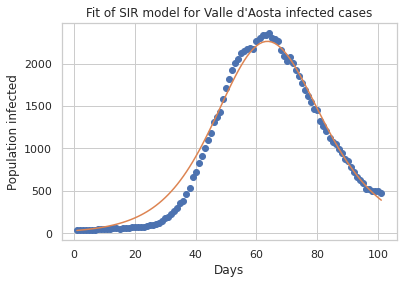

Optimal parameters: beta = 0.4954732995908  and gamma =  0.4049612106036211


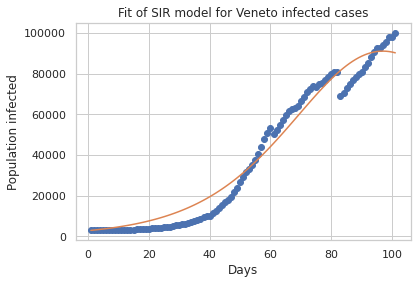

Optimal parameters: beta = 0.27323692217065687  and gamma =  0.22297802355902516


In [ ]:
for i in range(len(provinces)):
    SIR_fit(provinces[i])

# SIRD Model

In [ ]:
# The sird model
def SIRD_fit(region, wave_number = 1, starting_day = 1):
    region_df = provinces_df[region]
    cutoff_date = "2020-08-01"
    if wave_number == 1:
      region_df = region_df[region_df["data"] < cutoff_date]
    else:
      region_df = region_df[region_df["data"] >= cutoff_date]
    population = float(provinces_population[region])

    country_df = pd.DataFrame()
    country_df['ConfirmedCases'] = region_df.totale_positivi
    country_df['RemovedCases'] = region_df.dimessi_guariti + region_df.deceduti
    country_df['Mortality'] = provinces_df[region].deceduti.diff().fillna(0)
    country_df = country_df[starting_day:] #Choice of starting day.
    country_df['day_count'] = list(range(1,len(country_df)+1))

    ydata = [i for i in country_df.ConfirmedCases]
    removed_data = [i for i in country_df.RemovedCases]
    xdata = country_df.day_count
    ydata = np.array(ydata, dtype=float)
    xdata = np.array(xdata, dtype=float)
    mdata = [i for i in country_df.Mortality]

    N =  population
    init_case = ydata[0]
    init_removed = removed_data[0]
    S_0 = (N-init_case-init_removed)
    I_0 = init_case
    R_0 = init_removed
    M_0 = mdata[0]

    def sir_differentials(y, x, beta, gamma):
      S, I, R = y 
      sus = (-beta*S*I)/N
      rec = gamma*I
      inf = -(sus + rec)
      return sus, inf, rec

    def fit_odeint(x, beta, gamma):
      return integrate.odeint(sir_differentials, (S_0, I_0, R_0), x, args=(beta, gamma))[:,1]

    popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata, maxfev=10000)
    fitted = fit_odeint(xdata, *popt)
    
    #Find mu
    reg = LinearRegression().fit(ydata.reshape(-1, 1), mdata)
    mu = max(reg.coef_[0], 0)
    
    #Re-fit
    def sird_model(y, x, beta, gamma, mu):
        S, I, R, D = y 
        sus = (-beta*S*I)/N
        rec = gamma * I
        mort = mu * I
        inf = -(sus + rec + mort)
        return sus, inf, rec, mort

    fitted_data = integrate.odeint(sird_model, (S_0, I_0, R_0, M_0), xdata, args=(popt[0], popt[1] - mu, mu))

    #fitted = fitted_data[:,1]
    mort = ydata * mu
    
    plt.plot(xdata, mdata, 'o')
    plt.plot(xdata, mort)
    plt.title(f"Fit of SIRD model for {region} daily death cases for {wave_number} wave")
    plt.ylabel("Death cases")
    plt.xlabel("Days")
    plt.show()
    print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1] - mu, " and mu = ", mu)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


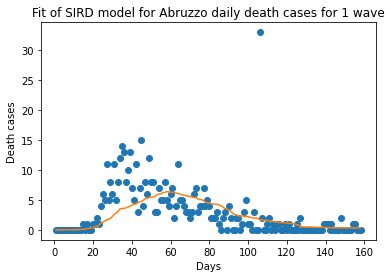

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters: beta = 1.0  and gamma =  0.9969684113809582  and mu =  0.0030315886190418486


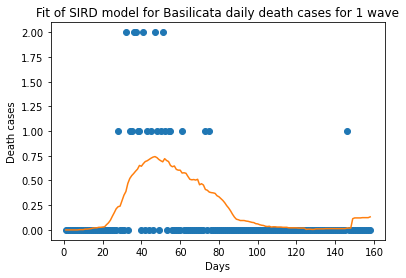

Optimal parameters: beta = 1.0  and gamma =  0.9973594919939294  and mu =  0.002640508006070583


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


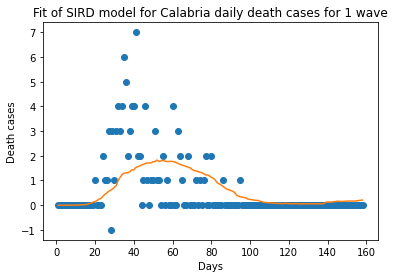

Optimal parameters: beta = 1.0  and gamma =  0.9978425526051979  and mu =  0.0021574473948020993


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


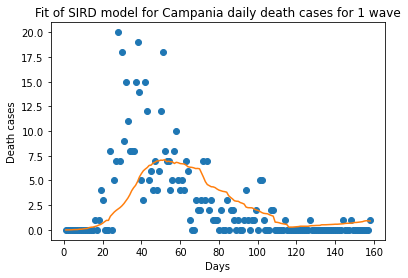

Optimal parameters: beta = 1.0  and gamma =  0.9977181404151101  and mu =  0.002281859584889965


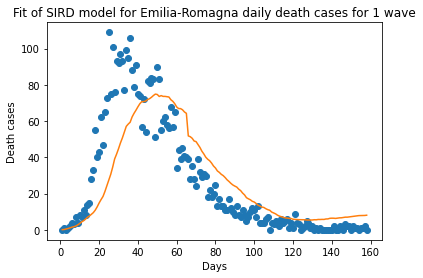

Optimal parameters: beta = 1.7237615972419822  and gamma =  1.5693307100894125  and mu =  0.005420033281919687


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


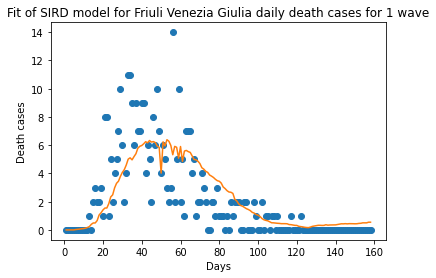

Optimal parameters: beta = 1.0  and gamma =  0.9955252374465962  and mu =  0.004474762553403834


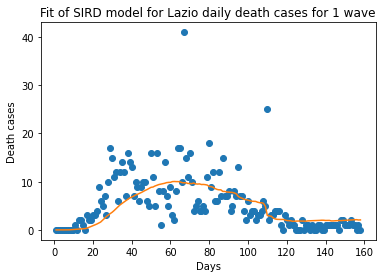

Optimal parameters: beta = 2.925817599483894  and gamma =  2.793684881491607  and mu =  0.0021968387628197787


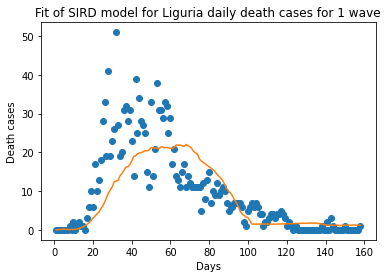

Optimal parameters: beta = 2.030545483529915  and gamma =  1.8677715259349887  and mu =  0.006122846925188153


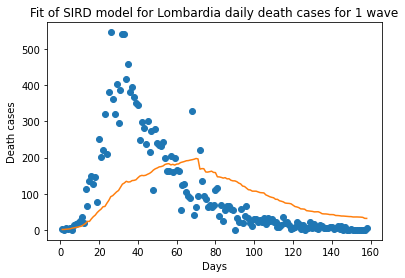

Optimal parameters: beta = 1.0653441433501383  and gamma =  0.963464754957284  and mu =  0.005288333706565566


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


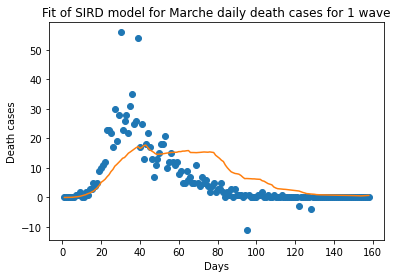

Optimal parameters: beta = 1.0  and gamma =  0.9952514244176677  and mu =  0.004748575582332309


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


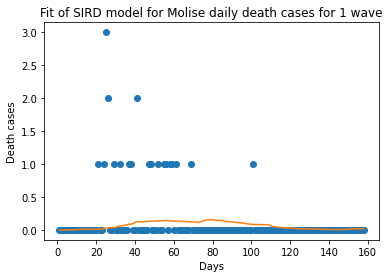

Optimal parameters: beta = 1.0  and gamma =  0.9993318923225434  and mu =  0.0006681076774566425


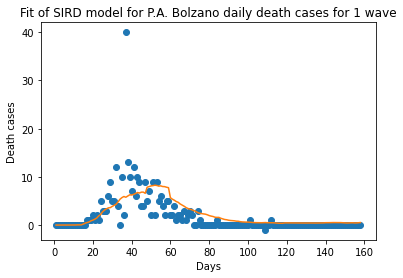

Optimal parameters: beta = 2.1169354599778614  and gamma =  1.9350671712464163  and mu =  0.005194208584626756


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


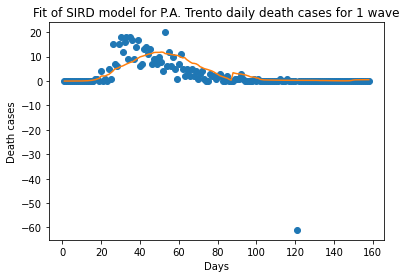

Optimal parameters: beta = 1.0  and gamma =  0.9943560559912717  and mu =  0.005643944008728209


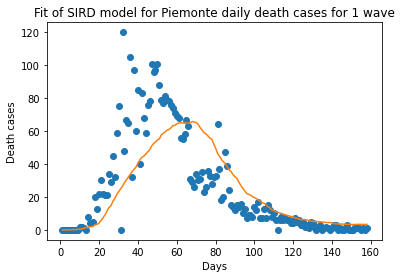

Optimal parameters: beta = 1.6496618960794276  and gamma =  1.488837947553387  and mu =  0.004185931005307697


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


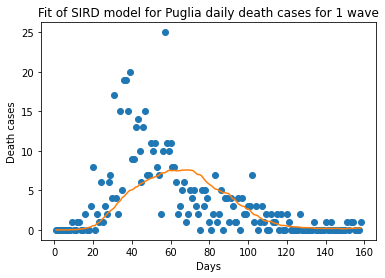

Optimal parameters: beta = 1.0  and gamma =  0.9974342707483502  and mu =  0.0025657292516497714


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


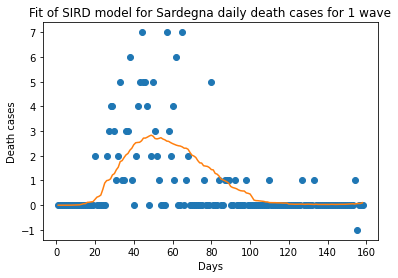

Optimal parameters: beta = 1.0  and gamma =  0.996898709917149  and mu =  0.003101290082850986


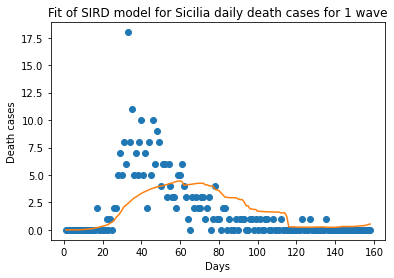

Optimal parameters: beta = 2.4090631885734464  and gamma =  2.3671328451162283  and mu =  0.0019283406721658427


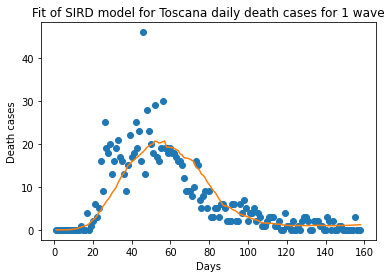

Optimal parameters: beta = 1.0228468414401808  and gamma =  0.9796251926085541  and mu =  0.0031243723971688887


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


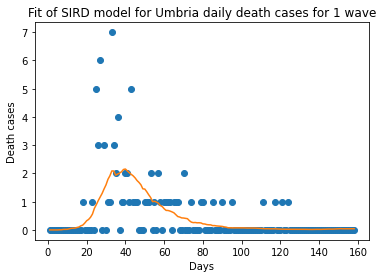

Optimal parameters: beta = 1.0  and gamma =  0.99767364228846  and mu =  0.0023263577115400003


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


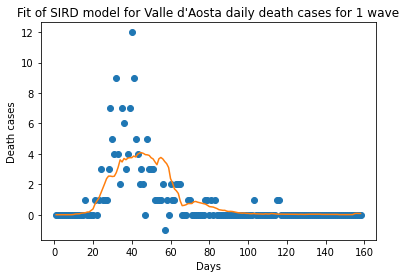

Optimal parameters: beta = 1.0  and gamma =  0.9933024701086027  and mu =  0.006697529891397221


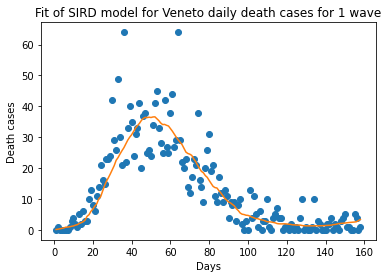

Optimal parameters: beta = 1.8724695851602216  and gamma =  1.7352177128354942  and mu =  0.0033901079457485006


In [ ]:
for i in range(len(provinces)):
    SIRD_fit(provinces[i], 1)

In [ ]:
for i in range(len(provinces)):
    SIRD_fit(provinces[i], 2)

#SIR Model (using Scipy)

In [ ]:
# read csv data file
covid_data_url = "https://msbdprojectstorage.blob.core.windows.net/msbd5008/dpc-covid19-ita-regioni.csv"
covid_data_file = 'dpc-covid19-ita-regioni.csv'
urllib.request.urlretrieve(covid_data_url, covid_data_file)
covid_data = pd.read_csv(covid_data_file)

covid_data
covid_data['data'] = pd.to_datetime(covid_data['data'], format="%Y-%m-%dT%H:%M:%S")
covid_data = covid_data.fillna(0)
del covid_data['note']
provinces = covid_data.denominazione_regione.unique()
provinces_df = {p:covid_data[covid_data["denominazione_regione"]==p] for p in provinces}

In [ ]:
# beta: individuals interaction rate
# gamma: patient death/recovery rate
# S(t): number of susceptible individuals at time t
# I(t): number of infected individuals at time t
# R(t): number of recovered individuals at time t
def sir_differentials(y, t, beta, gamma):
    S, I, R = y 
    d0 = -beta*S*I # derivative of S(t)
    d1 = beta*S*I-gamma*I # derivative of I(t)
    d2 = gamma*I # derivative of R(t)
    return [d0, d1, d2]

def sir_model(N, init_case, beta, gamma, t):
  # defining initial values
  S_0 = (N-init_case)/N
  I_0 = init_case/N
  R_0 = 0
  y_0 = [S_0,I_0,R_0]

  y = odeint(sir_differentials, y_0, t, args=(beta, gamma))
  S = y[:,0]
  I = y[:,1]
  R = y[:,2]
  return S, I, R

In [ ]:
ydata = [provinces_df[key]['totale_casi'] for key in provinces_df]
xdata = provinces_df["Abruzzo"]['data']

# ydata
xdata

0      2020-02-24 18:00:00
21     2020-02-25 18:00:00
42     2020-02-26 18:00:00
63     2020-02-27 18:00:00
84     2020-02-28 18:00:00
               ...        
5922   2020-12-02 17:00:00
5943   2020-12-03 17:00:00
5964   2020-12-04 17:00:00
5985   2020-12-05 17:00:00
6006   2020-12-06 17:00:00
Name: data, Length: 287, dtype: datetime64[ns]

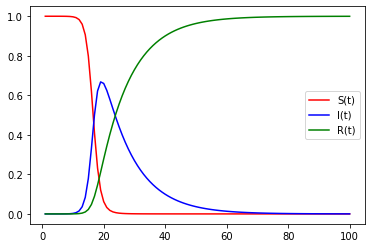

In [ ]:
population = float(1312000) #https://www.google.com/search?q=abruzzo+italy+population&oq=abruzzo+italy+popu&aqs=chrome.1.69i57j0i19j0i19i30.6447j0j1&sourceid=chrome&ie=UTF-8

ydata = [provinces_df[key]['totale_casi'] for key in provinces_df]
ydata = np.array(ydata, dtype=float)
inf0 = ydata[0][0] # SIR seems does not work with 0 initial case

# N: number of populations
# init_case: number of initial cases
# time_length: duration of the model
time_length = 100
t = np.linspace(start=1,stop=time_length,num=time_length)
S, I, R = sir_model(N=population, init_case=1, beta=1, gamma=0.1, t=t)
plt.plot(t,S,'r',label='S(t)')
plt.plot(t,I,'b',label='I(t)')
plt.plot(t,R,'g',label='R(t)')
plt.legend()
plt.show()

#SEIR Model

In [ ]:
# beta: individuals interaction rate
# gamma: patient death/recovery rate
# S(t): number of susceptible individuals at time t
# E(t): number of exposed individuals at time t
# I(t): number of infected individuals at time t
# R(t): number of recovered individuals at time t
N = float(1312000) #https://www.google.com/search?q=abruzzo+italy+population&oq=abruzzo+italy+popu&aqs=chrome.1.69i57j0i19j0i19i30.6447j0j1&sourceid=chrome&ie=UTF-8

def seir_differentials(y, t, beta, gamma, epsilon):
    S, E, I, R = y 
    d0 = (-beta*S*I)/N # derivative of S(t)
    d1 = (beta*S*I)/N-epsilon*E # derivative of E(t)
    d2 = epsilon*E-gamma*I # derivative of I(t)
    d3 = gamma*I # derivative of R(t)
    return [d0, d1, d2, d3]

def seir_model(N, init_case, beta, gamma, epsilon, t):
  # defining initial values
  S_0 = (N-init_case)
  E_0 = init_case
  I_0 = 0
  R_0 = 0
  y_0 = [S_0,E_0,I_0,R_0]

  y = odeint(seir_differentials, y_0, t, args=(beta, gamma, epsilon))
  S = y[:,0]
  E = y[:,1]
  I = y[:,2]
  R = y[:,3]
  return S, E, I, R

Basic Reroduction Number, R_0: 105.0.


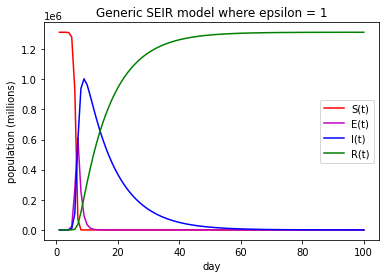

In [ ]:
population = float(1312000) #https://www.google.com/search?q=abruzzo+italy+population&oq=abruzzo+italy+popu&aqs=chrome.1.69i57j0i19j0i19i30.6447j0j1&sourceid=chrome&ie=UTF-8

ydata = [provinces_df[key]['totale_casi'] for key in provinces_df]
ydata = np.array(ydata, dtype=float)
inf0 = ydata[0][0] # SIR seems does not work with 0 initial case

# N: number of populations
# init_case: number of initial cases
# time_length: duration of the model
time_length = 100
t = np.linspace(start=1,stop=time_length,num=time_length)
contact_rate = 15                     # number of contacts per day
transmission_probability = 0.7       # virus transmission probability
infectious_period = 10                 # infectious period, time period that stay in hospital
latent_period = 1                     # latent period, time period that stay quarantine
beta_value = contact_rate * transmission_probability
gamma_value = 1 / infectious_period
epsilon_value = 1 / latent_period
print(f'Basic Reroduction Number, R_0: {beta_value/gamma_value}.')
S, E, I, R = seir_model(N=population, init_case=1, beta=beta_value, gamma=gamma_value, epsilon=epsilon_value, t=t)
plt.plot(t,S,'r',label='S(t)')
plt.plot(t,E,'m',label='E(t)')
plt.plot(t,I,'b',label='I(t)')
plt.plot(t,R,'g',label='R(t)')
plt.legend()
plt.title(f"Generic SEIR model where epsilon = {1}")
plt.xlabel('day')
plt.ylabel('population (millions)')
plt.show()

In [ ]:
# The seir main model
def SEIR_fit(region, wave_number, plot_graph = False):
    region_df = provinces_df[region]
    cutoff_date = "2020-08-01"
    if wave_number == 1:
      region_df = region_df[region_df["data"] < cutoff_date]
    else:
      region_df = region_df[region_df["data"] >= cutoff_date]
    population = float(provinces_population[region])

    country_df = pd.DataFrame()
    country_df['ConfirmedCases'] = region_df.totale_positivi
    country_df['IsolatedCases'] = region_df.isolamento_domiciliare
    country_df['RemovedCases'] = region_df.dimessi_guariti + region_df.deceduti
    #Choice of starting day.
    if wave_number == 1:
      country_df = country_df[28:] 
    else:
      country_df = country_df[60:] 
    country_df['day_count'] = list(range(1,len(country_df)+1))

    ydata = [i for i in country_df.ConfirmedCases]
    iso_data = [i for i in country_df.IsolatedCases]
    removed_data = [i for i in country_df.RemovedCases]
    xdata = country_df.day_count
    ydata = np.array(ydata, dtype=float)
    xdata = np.array(xdata, dtype=float)

    N =  population
    init_case = ydata[0]
    init_isolated = iso_data[0]
    init_removed = removed_data[0]
    S_0 = (N-init_case-init_isolated-init_removed)
    E_0 = init_isolated
    I_0 = init_case
    R_0 = init_removed

    def seir_differentials(y, x, beta, gamma, epsilon):
      S, E, I, R = y 
      d0 = (-beta*S*I)/N
      d1 = (beta*S*I)/N-epsilon*E
      d2 = epsilon*E-gamma*I
      d3 = -(d1+d1+d2)
      return d0, d1, d2, d3

    def fit_odeint(x, beta, gamma, epsilon):
      return integrate.odeint(seir_differentials, (S_0, E_0, I_0, R_0), x, args=(beta, gamma, epsilon))[:,1]

    popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
    fitted = fit_odeint(xdata, *popt)
    pred_beta = round(popt[0], 4)
    pred_gamma = round(popt[1], 4)
    pred_epsilon = round(popt[2], 4)
    r_0 = round(popt[0]/popt[1], 4)
    msle = mean_squared_log_error(ydata, fitted)

    if plot_graph:
      plt.plot(xdata, ydata, 'o')
      plt.plot(xdata, fitted)
      plt.title(f"Fit of SEIR model for {region} infected cases for {wave_number} wave")
      plt.ylabel("Population infected")
      plt.xlabel("Days")
      plt.show()
      print(f"Optimal parameters: beta = {pred_beta}, and gamma = {pred_gamma}, and epsilon = {pred_epsilon}")
      print(f'Basic Reroduction Number, R_0: {r_0}.')
      print(f'Model MSLE: {round(msle, 4)}.\n\n')
    
    return region, pred_beta, pred_gamma, pred_epsilon, r_0, msle

    

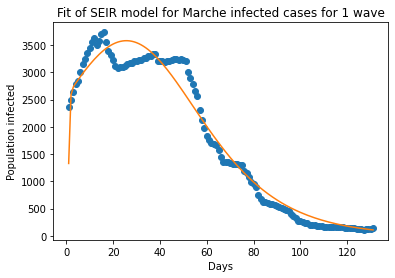

Optimal parameters: beta = 1.9315, and gamma = 1.8431, and epsilon = 0.7933
Basic Reroduction Number, R_0: 1.0479.
Model MSLE: 0.05.




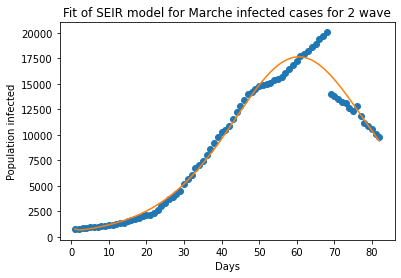

Optimal parameters: beta = 0.5174, and gamma = 0.3869, and epsilon = 0.7708
Basic Reroduction Number, R_0: 1.3374.
Model MSLE: 0.009.




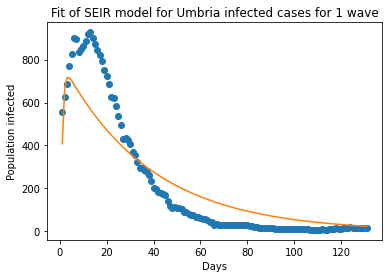

Optimal parameters: beta = 0.9603, and gamma = 1.1842, and epsilon = 0.1541
Basic Reroduction Number, R_0: 0.8109.
Model MSLE: 1.0352.




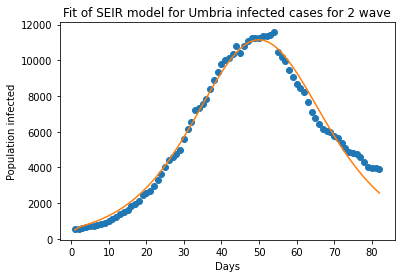

Optimal parameters: beta = 1.0146, and gamma = 0.808, and epsilon = 0.6485
Basic Reroduction Number, R_0: 1.2556.
Model MSLE: 0.0192.




('Umbria', 1.0146, 0.808, 0.6485, 1.2556, 0.01920427986871686)

In [ ]:
# import warnings
# warnings.filterwarnings('ignore')
SEIR_fit('Marche', 1, plot_graph = True)
SEIR_fit('Marche', 2, plot_graph = True)
SEIR_fit('Umbria', 1, plot_graph = True)
SEIR_fit('Umbria', 2, plot_graph = True)

In [ ]:
# first wave result
first_wave_df = pd.DataFrame(np.array(list(map(SEIR_fit, provinces, np.ones(len(provinces))))), columns=["province", "beta_1", "gamma_1", "epsilon_1", "r0_1", "MSLE_1"])
first_wave_df = first_wave_df.sort_values(by=['r0_1'], ascending=False)
first_wave_df

province   beta_1  ...    r0_1                MSLE_1
19          Valle d'Aosta   1.4224  ...  1.1184    0.6931249237894569
13               Piemonte    1.886  ...  1.1019   0.42952926270577835
12            P.A. Trento   1.9222  ...  1.0944    1.4276976767612681
11           P.A. Bolzano   1.9238  ...   1.087     3.570984154080638
8               Lombardia    1.365  ...  1.0739   0.03756752592716668
20                 Veneto    2.671  ...  1.0594    1.0256654816634887
9                  Marche   1.9315  ...  1.0479  0.049993225284578446
6                   Lazio   6.4851  ...   1.037   0.22467439591614374
5   Friuli Venezia Giulia   3.3703  ...  1.0358    0.5247701740836799
3                Campania   6.5367  ...  1.0327    1.2753791831532721
2                Calabria   5.8071  ...  1.0314    1.2463471004745326
15               Sardegna   6.7267  ...  1.0291    0.2726799363667373
17                Toscana   3.2178  ...   0.996    0.6631919290356215
4          Emilia-Romagna   5.3053  ...  0.9829     0.302297004958475
16                Sicilia  12.4784  ...  0.9812   0.21345590928258906
14                 Puglia   4.5305  ...  0.9808   0.24161785450358075
10                 Molise   9.7252  ...  0.9719   0.12373206605792442
0                 Abruzzo  11.9405  ...   0.965   0.08048147870319759
7                 Liguria   7.3555  ...  0.9648    0.3080008451103581
1              Basilicata   1.0041  ...  0.8864    1.8622060791305852
18                 Umbria   0.9603  ...  0.8109     1.035171686677332

[21 rows x 6 columns]

In [ ]:
# second wave result
second_wave_df = pd.DataFrame(np.array(list(map(SEIR_fit, provinces, np.ones(len(provinces))*2))), columns=["province", "beta_2", "gamma_2", "epsilon_2", "r0_2", "MSLE_2"])
second_wave_df = second_wave_df.sort_values(by=['r0_2'], ascending=False)
second_wave_df

province  beta_2  ...    r0_2                 MSLE_2
17                Toscana   0.422  ...  1.4761   0.009734983373924243
4          Emilia-Romagna  0.3573  ...  1.4521    0.00830176178171278
6                   Lazio  0.3731  ...  1.3995   0.004383061074966168
8               Lombardia  0.5513  ...  1.3813    0.03388280925824429
1              Basilicata  0.4048  ...  1.3662   0.015033235232491067
9                  Marche  0.5174  ...  1.3374   0.009012143025908541
3                Campania  0.6122  ...  1.3315   0.014828742447895032
7                 Liguria  0.4816  ...  1.3293   0.010349573097143471
13               Piemonte  0.8243  ...  1.3276    0.03553417124827252
0                 Abruzzo  0.5362  ...  1.3257  0.0031668690534219063
11           P.A. Bolzano  0.9856  ...   1.324     0.0824611617882864
14                 Puglia  0.4436  ...   1.308  0.0037925672614335516
5   Friuli Venezia Giulia  0.5971  ...  1.2856   0.006156039663658222
20                 Veneto  1.4415  ...  1.2575    0.10068549378497257
18                 Umbria  1.0146  ...  1.2556    0.01920427986871686
19          Valle d'Aosta  4.2321  ...  1.2554    0.11681117415827941
15               Sardegna  0.3914  ...  1.2549  0.0020671064555845076
16                Sicilia  0.5665  ...  1.2446  0.0022935051697135682
2                Calabria  0.5869  ...  1.2356   0.008773777606026425
10                 Molise  1.0002  ...  1.1995    0.07277821442158831
12            P.A. Trento  0.6393  ...  1.1742     0.0326293428984526

[21 rows x 6 columns]

In [ ]:
overall_seir_df = first_wave_df.merge(second_wave_df, on='province')
overall_seir_df["avg_r0"] = (pd.to_numeric(overall_seir_df["r0_1"]) + pd.to_numeric(overall_seir_df["r0_2"]))/2
overall_seir_df["diff_r0"] = pd.to_numeric(overall_seir_df["r0_2"]) - pd.to_numeric(overall_seir_df["r0_1"])
overall_seir_df["MSLE_sum"] = pd.to_numeric(overall_seir_df["MSLE_1"]) + pd.to_numeric(overall_seir_df["MSLE_2"])
overall_seir_df = overall_seir_df.sort_values(by=['avg_r0'], ascending=[False])
overall_seir_df

province   beta_1  gamma_1  ...   avg_r0 diff_r0  MSLE_sum
12                Toscana   3.2178   3.2307  ...  1.23605  0.4801  0.672927
4               Lombardia    1.365    1.271  ...  1.22760  0.3074  0.071450
7                   Lazio   6.4851   6.2539  ...  1.21825  0.3625  0.229057
13         Emilia-Romagna   5.3053   5.3974  ...  1.21750  0.4692  0.310599
1                Piemonte    1.886   1.7116  ...  1.21475  0.2257  0.465063
3            P.A. Bolzano   1.9238   1.7699  ...  1.20550  0.2370  3.653445
6                  Marche   1.9315   1.8431  ...  1.19265  0.2895  0.059005
0           Valle d'Aosta   1.4224   1.2719  ...  1.18690  0.1370  0.809936
9                Campania   6.5367   6.3298  ...  1.18210  0.2988  1.290208
8   Friuli Venezia Giulia   3.3703   3.2537  ...  1.16070  0.2498  0.530926
5                  Veneto    2.671   2.5213  ...  1.15845  0.1981  1.126351
18                Liguria   7.3555   7.6241  ...  1.14705  0.3645  0.318350
17                Abruzzo  11.9405  12.3739  ...  1.14535  0.3607  0.083648
15                 Puglia   4.5305   4.6194  ...  1.14440  0.3272  0.245410
11               Sardegna   6.7267   6.5364  ...  1.14200  0.2258  0.274747
2             P.A. Trento   1.9222   1.7564  ...  1.13430  0.0798  1.460327
10               Calabria   5.8071   5.6302  ...  1.13350  0.2042  1.255121
19             Basilicata   1.0041   1.1328  ...  1.12630  0.4798  1.877239
14                Sicilia  12.4784  12.7178  ...  1.11290  0.2634  0.215749
16                 Molise   9.7252  10.0061  ...  1.08570  0.2276  0.196510
20                 Umbria   0.9603   1.1842  ...  1.03325  0.4447  1.054376

[21 rows x 14 columns]

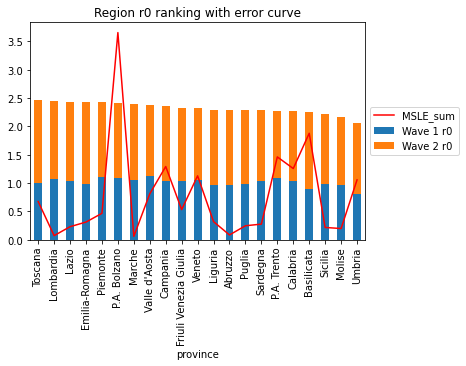

In [ ]:
avg_df = overall_seir_df[["province", "r0_1", "r0_2"]]
avg_df = avg_df.astype({'r0_1': float, 'r0_2': float})
avg_df = avg_df.rename(columns={'r0_1': "Wave 1 r0", 'r0_2': "Wave 2 r0"})
avg_df = avg_df.set_index('province')
ax = overall_seir_df[['province', 'MSLE_sum']].plot(x='province', linestyle='-', color='r')
avg_df.plot.bar(title="Region r0 ranking with error curve", stacked=True, ax=ax)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [ ]:
tmp_df = df.groupby("denominazione_regione")
maximums = tmp_df.max()
maximums.sort_values(by=['totale_positivi'], ascending=[False])

data  ... ingressi_terapia_intensiva
denominazione_regione                      ...                           
Lombardia             2020-12-20 17:00:00  ...                       62.0
Campania              2020-12-20 17:00:00  ...                        0.0
Veneto                2020-12-20 17:00:00  ...                       54.0
Lazio                 2020-12-20 17:00:00  ...                       30.0
Piemonte              2020-12-20 17:00:00  ...                       36.0
Emilia-Romagna        2020-12-20 17:00:00  ...                       24.0
Toscana               2020-12-20 17:00:00  ...                       18.0
Puglia                2020-12-20 17:00:00  ...                       42.0
Sicilia               2020-12-20 17:00:00  ...                       21.0
Marche                2020-12-20 17:00:00  ...                        6.0
Abruzzo               2020-12-20 17:00:00  ...                        8.0
Liguria               2020-12-20 17:00:00  ...                        5.0
Sardegna              2020-12-20 17:00:00  ...                        9.0
Friuli Venezia Giulia 2020-12-20 17:00:00  ...                        9.0
P.A. Bolzano          2020-12-20 17:00:00  ...                        3.0
Umbria                2020-12-20 17:00:00  ...                        8.0
Calabria              2020-12-20 17:00:00  ...                        5.0
Basilicata            2020-12-20 17:00:00  ...                        3.0
P.A. Trento           2020-12-20 17:00:00  ...                        7.0
Molise                2020-12-20 17:00:00  ...                        2.0
Valle d'Aosta         2020-12-20 17:00:00  ...                        4.0

[21 rows x 20 columns]